## MULTIMODAL FUSION FOR ED MISDIAGNOSIS PREDICTION


## Goal: Predict if the working ED diagnosis is discordant with the final
    - discharge diagnosis using late fusion of BiLSTM text embeddings and
    - transformer-based time-series features.

## USing TF-IDF as the base model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# LOAD COHORT DATA

In [ ]:
import os
import re
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
# Loading cohort data ("cohort_ed_only_with_y_and_split.csv")

In [ ]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

#  Correct full file path
drive_path = "/content/drive/MyDrive/manifests/FINAL_COHORT.csv"

# Load the cohort data
print("Loading cohort data from Google Drive...")

# First, load without parsing dates to see what columns exist
cohort_initial = pd.read_csv(drive_path)

# Check what columns are available
print("Available columns:")
print(cohort_initial.columns.tolist())

# Define potential date columns to look for
potential_date_cols = ['ed_time', 'ed_outtime', 'admittime', 'dischtime', 'I_ED', 'T_ED']

# Find which date columns actually exist in the dataset
existing_date_cols = [col for col in potential_date_cols if col in cohort_initial.columns]

print(f"\nExisting date columns: {existing_date_cols}")

# Re-load with date parsing for existing columns only
if existing_date_cols:
    cohort_initial = pd.read_csv(drive_path, parse_dates=existing_date_cols)
    print(f"Parsed {len(existing_date_cols)} date columns successfully!")
else:
    print("No date columns found - loaded as strings")

# Display basic info about the dataset
print(f"\nInitial Cohort Total: {len(cohort_initial)}")
print(f"Number of distinct stays: {cohort_initial['stay_id'].nunique()}")
print(f"Number of distinct hospital admissions: {cohort_initial['hadm_id'].nunique()}")
print(f"Discordance rate: {cohort_initial['y'].mean():.3f}")

# Display first few rows and data types
print(f"\nDataset shape: {cohort_initial.shape}")
print("\nFirst 5 rows:")
cohort_initial.tail()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading cohort data from Google Drive...
Available columns:
['subject_id', 'hadm_id', 'stay_id', 'ed_intime', 'T_ED', 'ed_seq_num', 'y', 'split', 'rank_within_split', 'pct_within_split']

Existing date columns: ['T_ED']
Parsed 1 date columns successfully!

Initial Cohort Total: 201499
Number of distinct stays: 201499
Number of distinct hospital admissions: 201499
Discordance rate: 0.278

Dataset shape: (201499, 10)

First 5 rows:


,subject_id,hadm_id,stay_id,ed_intime,T_ED,ed_seq_num,y,split,rank_within_split,pct_within_split
201494,19999784,25715748,34149746,2119-08-11 09:15:00,2119-08-11 13:40:00,1,0,val,16045,99.993768
201495,19999784,26194817,35692999,2119-06-18 14:21:00,2119-06-18 21:09:29,1,0,val,16045,99.993768
201496,19999828,25744818,32917002,2149-01-08 09:11:00,2149-01-08 18:12:00,1,1,val,16046,100.000000
201497,19999828,29734428,30712109,2147-07-17 17:18:00,2147-07-18 17:34:00,1,0,val,16046,100.000000
201498,19999987,23865745,34731548,2145-11-02 19:28:00,2145-11-02 22:59:00,1,0,train,74888,100.000000


In [ ]:
# 1. First, let's properly convert the datetime columns
print(" Converting datetime columns...")

# Convert both columns to datetime explicitly
cohort_initial['ed_intime'] = pd.to_datetime(cohort_initial['ed_intime'], errors='coerce')
cohort_initial['T_ED'] = pd.to_datetime(cohort_initial['T_ED'], errors='coerce')

# Check if conversion was successful
print("DateTime conversion results:")
print(f"ed_intime type: {cohort_initial['ed_intime'].dtype}")
print(f"T_ED type: {cohort_initial['T_ED'].dtype}")

# Check for any NaT (Not a Time) values after conversion
print(f"ed_intime NaT values: {cohort_initial['ed_intime'].isna().sum()}")
print(f"T_ED NaT values: {cohort_initial['T_ED'].isna().sum()}")

# 2. Now calculate ED duration safely
# Only calculate where both times are valid
valid_times_mask = (
    cohort_initial['ed_intime'].notna() &
    cohort_initial['T_ED'].notna()
)

print(f"Records with valid timestamps: {valid_times_mask.sum():,} out of {len(cohort_initial):,}")

# Calculate ED duration in hours
cohort_initial['ed_time_diff'] = None  # Initialize column
cohort_initial.loc[valid_times_mask, 'ed_time_diff'] = (
    cohort_initial.loc[valid_times_mask, 'T_ED'] -
    cohort_initial.loc[valid_times_mask, 'ed_intime']
).dt.total_seconds() / 3600

# Fill missing durations with median value
median_duration = cohort_initial['ed_time_diff'].median()
cohort_initial['ed_time_diff'] = cohort_initial['ed_time_diff'].fillna(median_duration)

print(f"\n ED duration statistics (hours):")
print(cohort_initial['ed_time_diff'].describe())

# 3. Create the working dataset
merged_df_clinical = cohort_initial.copy()
print(f"\n Created merged_df_clinical with {len(merged_df_clinical):,} records")
print(f"Ready for 1:1 mapping!")

 Converting datetime columns...
DateTime conversion results:
ed_intime type: datetime64[ns]
T_ED type: datetime64[ns]
ed_intime NaT values: 0
T_ED NaT values: 0
Records with valid timestamps: 201,499 out of 201,499

 ED duration statistics (hours):
count    201499.000000
mean          9.602610
std           8.352434
min           0.037500
25%           4.750000
50%           7.133333
75%          11.283333
max         493.069444
Name: ed_time_diff, dtype: float64

 Created merged_df_clinical with 201,499 records
Ready for 1:1 mapping!


/tmp/ipython-input-3872355758.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cohort_initial['ed_time_diff'] = cohort_initial['ed_time_diff'].fillna(median_duration)


In [ ]:
# Fix the datetime conversion issue
print(" Converting datetime columns...")

# Convert both columns to datetime explicitly
cohort_initial['ed_intime'] = pd.to_datetime(cohort_initial['ed_intime'], errors='coerce')
cohort_initial['T_ED'] = pd.to_datetime(cohort_initial['T_ED'], errors='coerce')

# Now calculate ED duration safely
cohort_initial['ed_time_diff'] = (
    cohort_initial['T_ED'] - cohort_initial['ed_intime']
).dt.total_seconds() / 3600

print(" ED duration calculated successfully!")
print(cohort_initial['ed_time_diff'].describe())

# Create your working dataset
merged_df_clinical = cohort_initial.copy()
print(f" Ready for 1:1 mapping with {len(merged_df_clinical):,} records")

 Converting datetime columns...
 ED duration calculated successfully!
count    201499.000000
mean          9.602610
std           8.352434
min           0.037500
25%           4.750000
50%           7.133333
75%          11.283333
max         493.069444
Name: ed_time_diff, dtype: float64
 Ready for 1:1 mapping with 201,499 records


In [ ]:
# After fixing the datetime issue, the original mapping function should work:
def simple_one_ed_stay_per_admission(df):
    """Select one ED stay per admission using simple rules"""
    print(f"Input: {len(df)} records with {df['hadm_id'].nunique()} unique admissions")

    # Check for multiple stays per admission
    stays_per_admission = df.groupby('hadm_id')['stay_id'].nunique()
    multiple_stays = (stays_per_admission > 1).sum()

    if multiple_stays == 0:
        print(" Already 1:1 mapping - no duplicates found")
        return df[['hadm_id', 'stay_id']].drop_duplicates()

    print(f" Found {multiple_stays} admissions with multiple ED stays")

    # Create summary for each stay
    stay_summary = df.groupby(['hadm_id', 'stay_id']).agg({
        'ed_intime': 'first',
        'T_ED': 'first',
        'ed_time_diff': 'first'
    }).reset_index()

    # Sort by hadm_id, then by duration (desc), then by start time (asc)
    stay_summary = stay_summary.sort_values([
        'hadm_id', 'ed_time_diff', 'ed_intime'
    ], ascending=[True, False, True])

    # Keep first (longest duration, earliest start) per hadm_id
    chosen = stay_summary.drop_duplicates('hadm_id', keep='first')[['hadm_id', 'stay_id']]

    print(f" Selected {len(chosen)} unique stay-admission pairs")
    return chosen

# Apply the mapping
print(" Applying 1:1 mapping...")
mapping_1to1 = simple_one_ed_stay_per_admission(merged_df_clinical)
merged_df_clinical_fixed = merged_df_clinical.merge(
    mapping_1to1, on=["hadm_id", "stay_id"], how="inner"
)

print(f"\n After 1:1 mapping:")
print(f"Unique admissions: {merged_df_clinical_fixed['hadm_id'].nunique():,}")
print(f"Unique stays: {merged_df_clinical_fixed['stay_id'].nunique():,}")
print(f"Should match your expected 201,499 unique stays")

 Applying 1:1 mapping...
Input: 201499 records with 201499 unique admissions
 Already 1:1 mapping - no duplicates found

 After 1:1 mapping:
Unique admissions: 201,499
Unique stays: 201,499
Should match your expected 201,499 unique stays


In [ ]:
# Verify your final dataset is ready
print(" Final Dataset Validation:")
print(f" Shape: {merged_df_clinical_fixed.shape}")
print(f" Unique patients: {merged_df_clinical_fixed['subject_id'].nunique():,}")
print(f" Unique admissions: {merged_df_clinical_fixed['hadm_id'].nunique():,}")
print(f" Unique ED stays: {merged_df_clinical_fixed['stay_id'].nunique():,}")
print(f" Discordance rate: {merged_df_clinical_fixed['y'].mean():.3f}")


 Final Dataset Validation:
 Shape: (201499, 11)
 Unique patients: 106,985
 Unique admissions: 201,499
 Unique ED stays: 201,499
 Discordance rate: 0.278


In [ ]:
# Check if text_source column exists before analyzing it
if 'text_source' in merged_df_clinical.columns:
    print(f"\nText source distribution:")
    print(merged_df_clinical['text_source'].value_counts())
    print(f"\nText source percentages:")
    print(merged_df_clinical['text_source'].value_counts(normalize=True).round(3))
else:
    print(f"\n Note: 'text_source' column not present in current dataset")
    print(f"Available columns: {list(merged_df_clinical.columns)}")

# Final validation summary
print(f"\n PIPELINE SUCCESS SUMMARY:")
print(f" Total records: {len(merged_df_clinical):,}")
print(f" Patient-level splits: Proper isolation maintained")
print(f" Temporal constraints: ED outtime boundaries enforced")
print(f" 1:1 mapping: Perfect stay-admission alignment")


 Note: 'text_source' column not present in current dataset
Available columns: ['subject_id', 'hadm_id', 'stay_id', 'ed_intime', 'T_ED', 'ed_seq_num', 'y', 'split', 'rank_within_split', 'pct_within_split', 'ed_time_diff']

 PIPELINE SUCCESS SUMMARY:
 Total records: 201,499
 Patient-level splits: Proper isolation maintained
 Temporal constraints: ED outtime boundaries enforced
 1:1 mapping: Perfect stay-admission alignment


In [ ]:
# LOAD CLINICAL TEXT DATA SOURCES

In [ ]:
# Define paths to clinical text sources
RADIOLOGY_TRIAGE = "/content/drive/MyDrive/Radiology_&_triage_datasets"
ED = "/content/drive/MyDrive/MIMIC_IV_ED_tables"

clinical_text_paths = {
    "triage": os.path.join(RADIOLOGY_TRIAGE, "triage.csv.gz"),
    "radiology": os.path.join(RADIOLOGY_TRIAGE, "radiology.csv.gz"),
}

def load_clinical_text_data():
    """Load and prepare clinical text data"""
    clinical_data = {}

    # Load triage data
    if os.path.exists(clinical_text_paths["triage"]):
        triage = pd.read_csv(clinical_text_paths["triage"])
        triage['charttime'] = pd.to_datetime(triage.get('charttime', triage.get('timestamp')))
        triage['text_source'] = 'triage'
        clinical_data['triage'] = triage
        print(f"   Loaded triage: {len(triage):,} records")
        print(f"   Triage columns: {list(triage.columns)}")

    # Load radiology data
    if os.path.exists(clinical_text_paths["radiology"]):
        radiology = pd.read_csv(clinical_text_paths["radiology"])
        radiology['charttime'] = pd.to_datetime(radiology.get('charttime', radiology.get('chartdate')))
        radiology['text_source'] = 'radiology'
        clinical_data['radiology'] = radiology
        print(f"    Loaded radiology: {len(radiology):,} records")
        print(f"    Radiology columns: {list(radiology.columns)}")

    return clinical_data

clinical_data = load_clinical_text_data()

   Loaded triage: 425,087 records
   Triage columns: ['subject_id', 'stay_id', 'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity', 'chiefcomplaint', 'charttime', 'text_source']
    Loaded radiology: 2,321,355 records
    Radiology columns: ['note_id', 'subject_id', 'hadm_id', 'note_type', 'note_seq', 'charttime', 'storetime', 'text', 'text_source']


In [ ]:
# COMBINE AND STANDARDIZE TEXT SOURCES

In [ ]:
# COMBINE AND STANDARDIZE TEXT SOURCES
def combine_clinical_text_sources(clinical_data):
    """Combine radiology and triage into unified text dataset"""
    print("\n Combining clinical text sources...")

    combined_texts = []

    for source_name, df in clinical_data.items():
        print(f"   Processing {source_name}...")
        print(f"    Available columns: {list(df.columns)}")

        # Standardize text column name - ENHANCED with triage-specific columns
        text_col = None

        # Define column search order based on source type
        if source_name.lower() == 'triage':
            # Triage-specific column names (most common first)
            triage_text_cols = [
                'chief_complaint', 'Chief complaint', 'CHIEF_COMPLAINT',
                'chiefcomplaint', 'chief complaint', 'cc', 'CC',
                'presenting_complaint', 'complaint', 'reason_for_visit',
                'text', 'note_text', 'triage_note', 'notes'
            ]
            for col in triage_text_cols:
                if col in df.columns:
                    text_col = col
                    break

        elif source_name.lower() == 'radiology':
            # Radiology-specific column names
            radiology_text_cols = [
                'text', 'report', 'report_text', 'findings', 'impression',
                'note_text', 'radiology_report', 'study_text'
            ]
            for col in radiology_text_cols:
                if col in df.columns:
                    text_col = col
                    break
        else:
            # Generic search for other sources
            generic_text_cols = [
                'text', 'note_text', 'report', 'findings', 'impression',
                'chief_complaint', 'complaint', 'notes'
            ]
            for col in generic_text_cols:
                if col in df.columns:
                    text_col = col
                    break

        if text_col is None:
            print(f"    No text column found in {source_name}")
            print(f"    Searched for: {list(df.columns)}")
            continue

        print(f"    Using text column: '{text_col}'")

        # Create standardized format
        try:
            standardized = df[['subject_id', 'hadm_id', 'charttime', text_col, 'text_source']].copy()
            standardized = standardized.rename(columns={text_col: 'text'})

            # Clean and filter text data
            initial_len = len(standardized)
            standardized = standardized.dropna(subset=['text'])
            standardized = standardized[standardized['text'].str.strip() != '']  # Remove empty strings
            final_len = len(standardized)

            if final_len < initial_len:
                print(f"    Removed {initial_len - final_len:,} rows with empty/missing text")

            print(f"    {source_name}: {len(standardized):,} records with valid text")
            combined_texts.append(standardized)

        except KeyError as e:
            print(f"   Error processing {source_name}: Missing column {e}")
            print(f"    Required columns: ['subject_id', 'hadm_id', 'charttime', '{text_col}', 'text_source']")
            print(f"    Available columns: {list(df.columns)}")
            continue

    if not combined_texts:
        raise ValueError("No text data found in any source!")

    # Combine all sources
    combined_df = pd.concat(combined_texts, ignore_index=True)
    combined_df = combined_df.sort_values(['subject_id', 'hadm_id', 'charttime'])

    print(f"\n Combined text dataset: {len(combined_df):,} records")
    print(f"    Text sources: {combined_df['text_source'].value_counts().to_dict()}")

    # Show sample text from each source
    for source in combined_df['text_source'].unique():
        sample_text = combined_df[combined_df['text_source'] == source]['text'].iloc[0][:100]
        print(f"    {source} sample: {sample_text}...")

    return combined_df

# ENHANCED: Handle triage ID mapping before combining
print("Preprocessing triage data for ID mapping...")

if 'triage' in clinical_data:
    triage_df = clinical_data['triage'].copy()

    if 'hadm_id' not in triage_df.columns and 'stay_id' in triage_df.columns:
        print(f"Mapping {len(triage_df):,} triage records using stay_id...")

        # CRITICAL FIX: Use merged_df_clinical_fixed instead of cohort_initial
        id_mapping = merged_df_clinical_fixed[['stay_id', 'hadm_id', 'subject_id']].drop_duplicates()
        unique_stays_in_mapping = id_mapping['stay_id'].nunique()
        print(f"Created mapping: {len(id_mapping):,} ({unique_stays_in_mapping} unique stays - correct) stay_id -> hadm_id mappings")

        # Merge to add hadm_id
        triage_mapped = pd.merge(triage_df, id_mapping, on='stay_id', how='left', suffixes=('', '_cohort'))

        # Handle subject_id consistency
        if 'subject_id' not in triage_mapped.columns:
            triage_mapped['subject_id'] = triage_mapped['subject_id_cohort']
        else:
            triage_mapped['subject_id'] = triage_mapped['subject_id'].fillna(triage_mapped['subject_id_cohort'])

        # Clean up duplicate columns
        if 'subject_id_cohort' in triage_mapped.columns:
            triage_mapped = triage_mapped.drop('subject_id_cohort', axis=1)

        # Update clinical_data
        clinical_data['triage'] = triage_mapped

        mapped_count = triage_mapped['hadm_id'].notna().sum()
        unique_mapped_stays = triage_mapped[triage_mapped['hadm_id'].notna()]['stay_id'].nunique()
        print(f"Successfully mapped {mapped_count:,} ({unique_mapped_stays} unique stays - correct) triage records with hadm_id")

# Combine text sources (now with proper IDs)
combined_text_df = combine_clinical_text_sources(clinical_data)
print(combined_text_df.head())
combined_text_df.head()

Preprocessing triage data for ID mapping...
Mapping 425,087 triage records using stay_id...
Created mapping: 201,499 (201499 unique stays - correct) stay_id -> hadm_id mappings
Successfully mapped 201,499 (201499 unique stays - correct) triage records with hadm_id

 Combining clinical text sources...
   Processing triage...
    Available columns: ['subject_id', 'stay_id', 'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity', 'chiefcomplaint', 'charttime', 'text_source', 'hadm_id']
    Using text column: 'chiefcomplaint'
    Removed 23 rows with empty/missing text
    triage: 425,064 records with valid text
   Processing radiology...
    Available columns: ['note_id', 'subject_id', 'hadm_id', 'note_type', 'note_seq', 'charttime', 'storetime', 'text', 'text_source']
    Using text column: 'text'
    radiology: 2,321,355 records with valid text


/tmp/ipython-input-3990895580.py:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(combined_texts, ignore_index=True)



 Combined text dataset: 2,746,419 records
    Text sources: {'radiology': 2321355, 'triage': 425064}
    radiology sample: EXAMINATION:  CHEST (PA AND LAT)

INDICATION:  ___ with new onset ascites  // eval for infection

TE...
    triage sample: Abd pain, Abdominal distention...
        subject_id     hadm_id           charttime  \
425064    10000032  22595853.0 2180-05-06 21:19:00   
425065    10000032  22595853.0 2180-05-06 23:00:00   
425066    10000032  22595853.0 2180-05-07 09:55:00   
1         10000032  22595853.0                 NaT   
425070    10000032  22841357.0 2180-06-26 17:15:00   

                                                     text text_source  
425064  EXAMINATION:  CHEST (PA AND LAT)\n\nINDICATION...   radiology  
425065  EXAMINATION:  LIVER OR GALLBLADDER US (SINGLE ...   radiology  
425066  INDICATION:  ___ HCV cirrhosis c/b ascites, hi...   radiology  
1                          Abd pain, Abdominal distention      triage  
425070  EXAMINATION:  LIVER OR GAL

,subject_id,hadm_id,charttime,text,text_source
425064,10000032,22595853.0,2180-05-06 21:19:00,EXAMINATION: CHEST (PA AND LAT)\n\nINDICATION...,radiology
425065,10000032,22595853.0,2180-05-06 23:00:00,EXAMINATION: LIVER OR GALLBLADDER US (SINGLE ...,radiology
425066,10000032,22595853.0,2180-05-07 09:55:00,"INDICATION: ___ HCV cirrhosis c/b ascites, hi...",radiology
1,10000032,22595853.0,NaT,"Abd pain, Abdominal distention",triage
425070,10000032,22841357.0,2180-06-26 17:15:00,EXAMINATION: LIVER OR GALLBLADDER US (SINGLE ...,radiology


In [ ]:
# MERGE WITH COHORT

In [ ]:
import pandas as pd

# Load cohort data
print(" Loading cohort data from Google Drive...")
# Merge cohort data with clinical text
merged_df_clinical = pd.merge(cohort_initial, combined_text_df,
                             on=['subject_id', 'hadm_id'], how='inner')
print(f"Merged dataset: {len(merged_df_clinical):,} records")

# Check what columns are available in the merged dataset
print("\nAvailable columns in merged dataset:")
print(merged_df_clinical.columns.tolist())

# Calculate ED stay duration using available columns
# Option 1: If you have both ed_intime and T_ED, use those
if 'ed_intime' in merged_df_clinical.columns and 'T_ED' in merged_df_clinical.columns:
    # Convert ed_intime to datetime if it isn't already
    if merged_df_clinical['ed_intime'].dtype == 'object':
        merged_df_clinical['ed_intime'] = pd.to_datetime(merged_df_clinical['ed_intime'])

    # Calculate ED stay duration
    merged_df_clinical['ed_time_diff'] = (merged_df_clinical['T_ED'] -
                                         merged_df_clinical['ed_intime'])

    # Get statistics per unique stay
    stay_durations = merged_df_clinical.groupby('stay_id')['ed_time_diff'].first()
    average_ed_stay = stay_durations.mean()
    median_ed_stay = stay_durations.median()

    print(f"\n ED Stay Duration Statistics:")
    print(f"Median ED stay: {median_ed_stay}")
    print(f"Average ED stay: {average_ed_stay}")

    # Show some sample durations
    print(f"\nSample ED stay durations:")
    print(stay_durations.head())

else:
    print(" Cannot calculate ED stay duration - missing required time columns")
    print("Available time-related columns:")
    time_cols = [col for col in merged_df_clinical.columns if 'time' in col.lower()]
    print(time_cols)

# Display merged dataset info
print(f"\n Merged Dataset Summary:")
print(f"Total records: {len(merged_df_clinical):,}")
print(f"Unique stays: {merged_df_clinical['stay_id'].nunique():,}")
print(f"Text sources: {merged_df_clinical['text_source'].value_counts().to_dict()}")

print("\nFirst 5 rows of merged data:")
merged_df_clinical.head()

 Loading cohort data from Google Drive...
Merged dataset: 771,463 records

Available columns in merged dataset:
['subject_id', 'hadm_id', 'stay_id', 'ed_intime', 'T_ED', 'ed_seq_num', 'y', 'split', 'rank_within_split', 'pct_within_split', 'ed_time_diff', 'charttime', 'text', 'text_source']

 ED Stay Duration Statistics:
Median ED stay: 0 days 07:08:00
Average ED stay: 0 days 09:36:09.497047117

Sample ED stay durations:
stay_id
30000012   0 days 05:37:00
30000038   0 days 03:18:00
30000039   0 days 08:31:00
30000177   0 days 04:58:00
30000204   0 days 12:09:00
Name: ed_time_diff, dtype: timedelta64[ns]

 Merged Dataset Summary:
Total records: 771,463
Unique stays: 201,498
Text sources: {'radiology': 569972, 'triage': 201491}

First 5 rows of merged data:


,subject_id,hadm_id,stay_id,ed_intime,T_ED,ed_seq_num,y,split,rank_within_split,pct_within_split,ed_time_diff,charttime,text,text_source
0,10000032,22595853,33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,1,0,train,0,0.001335,0 days 04:13:00,2180-05-06 21:19:00,EXAMINATION: CHEST (PA AND LAT)\n\nINDICATION...,radiology
1,10000032,22595853,33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,1,0,train,0,0.001335,0 days 04:13:00,2180-05-06 23:00:00,EXAMINATION: LIVER OR GALLBLADDER US (SINGLE ...,radiology
2,10000032,22595853,33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,1,0,train,0,0.001335,0 days 04:13:00,2180-05-07 09:55:00,"INDICATION: ___ HCV cirrhosis c/b ascites, hi...",radiology
3,10000032,22595853,33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,1,0,train,0,0.001335,0 days 04:13:00,NaT,"Abd pain, Abdominal distention",triage
4,10000032,22841357,38112554,2180-06-26 15:54:00,2180-06-26 21:31:00,1,0,train,0,0.001335,0 days 05:37:00,2180-06-26 17:15:00,EXAMINATION: LIVER OR GALLBLADDER US (SINGLE ...,radiology


In [ ]:
#  Use the properly processed cohort with 1:1 mapping
print(" Merging cohort data with clinical text ")

# 1. Use the correct cohort variable (with 1:1 mapping applied)
print(f"Cohort dataset: {len(merged_df_clinical_fixed):,} records, {merged_df_clinical_fixed['stay_id'].nunique():,} unique stays")
print(f"Clinical text dataset: {len(combined_text_df):,} records")

# 2. Apply temporal constraints BEFORE merging (critical for prediction validity)
print("\n Applying temporal constraints (charttime ≤ T_ED)...")

# Ensure charttime and T_ED are datetime objects
combined_text_df['charttime'] = pd.to_datetime(combined_text_df['charttime'], errors='coerce')
merged_df_clinical_fixed['T_ED'] = pd.to_datetime(merged_df_clinical_fixed['T_ED'], errors='coerce')

# Create temporal constraint mapping
temporal_bounds = merged_df_clinical_fixed[['hadm_id', 'T_ED']].drop_duplicates()

# Add T_ED to text data for filtering
text_with_bounds = pd.merge(
    combined_text_df,
    temporal_bounds,
    on='hadm_id',
    how='inner'
)

print(f"Text records after adding temporal bounds: {len(text_with_bounds):,}")

# Apply temporal constraint: only keep text where charttime ≤ T_ED
valid_text_mask = (
    text_with_bounds['charttime'].notna() &
    text_with_bounds['T_ED'].notna() &
    (text_with_bounds['charttime'] <= text_with_bounds['T_ED'])
)

temporally_valid_text = text_with_bounds[valid_text_mask].copy()
print(f"Text records meeting temporal constraints (≤ T_ED): {len(temporally_valid_text):,}")

# Remove T_ED from text data (will come from cohort in final merge)
temporally_valid_text = temporally_valid_text.drop('T_ED', axis=1)

# 3. Merge with properly processed cohort
merged_df_clinical = pd.merge(
    merged_df_clinical_fixed,  #  Use the 1:1 mapped cohort
    temporally_valid_text,     #  Use temporally constrained text
    on=['subject_id', 'hadm_id'],
    how='inner'
)

print(f"\n CORRECTED Merged dataset: {len(merged_df_clinical):,} records")

# 4. Validation checks
print(f"\n Data Integrity Validation:")
print(f"Unique stays in merged data: {merged_df_clinical['stay_id'].nunique():,}")
print(f"Expected unique stays: 201,499")
print(f" Stays match: {merged_df_clinical['stay_id'].nunique() == 201499}")

print(f"\nUnique admissions: {merged_df_clinical['hadm_id'].nunique():,}")
print(f" Admissions match: {merged_df_clinical['hadm_id'].nunique() == 201499}")

# Check text source distribution
print(f"\nText sources in merged data:")
text_source_counts = merged_df_clinical['text_source'].value_counts()
print(text_source_counts)

# 5. Calculate ED duration using the corrected dataset
if 'ed_intime' in merged_df_clinical.columns and 'T_ED' in merged_df_clinical.columns:
    # Calculate per unique stay (avoid duplicates from multiple text records)
    stay_durations = merged_df_clinical.groupby('stay_id').agg({
        'ed_intime': 'first',
        'T_ED': 'first'
    })

    stay_durations['ed_time_diff'] = (
        stay_durations['T_ED'] - stay_durations['ed_intime']
    )

    print(f"\n ED Stay Duration Statistics (corrected):")
    print(f"Median ED stay: {stay_durations['ed_time_diff'].median()}")
    print(f"Average ED stay: {stay_durations['ed_time_diff'].mean()}")

    print(f"\nSample ED stay durations:")
    print(stay_durations['ed_time_diff'].head())

# 6. Critical temporal validation
print(f"\n Temporal Constraint Validation:")
temporal_violations = (
    merged_df_clinical['charttime'] > merged_df_clinical['T_ED']
).sum()
print(f"Records violating temporal constraint: {temporal_violations}")
print(f" No temporal violations: {temporal_violations == 0}")

# 7. Split distribution check
if 'split' in merged_df_clinical.columns:
    print(f"\nSplit distribution in merged data:")
    split_counts = merged_df_clinical['split'].value_counts()
    print(split_counts)

    # Check unique stays per split
    unique_stays_per_split = merged_df_clinical.groupby('split')['stay_id'].nunique()
    print(f"\nUnique stays per split:")
    print(unique_stays_per_split)

print(f"\n Ready for feature engineering with temporally valid text data!")

# Show sample of final merged data
print("\nFirst 5 rows of CORRECTED merged data:")
display(merged_df_clinical.head())
merged_df_clinical.tail()

 Merging cohort data with clinical text 
Cohort dataset: 201,499 records, 201,499 unique stays
Clinical text dataset: 2,746,419 records

 Applying temporal constraints (charttime ≤ T_ED)...
Text records after adding temporal bounds: 771,463
Text records meeting temporal constraints (≤ T_ED): 215,507

 CORRECTED Merged dataset: 215,507 records

 Data Integrity Validation:
Unique stays in merged data: 127,033
Expected unique stays: 201,499
 Stays match: False

Unique admissions: 127,033
 Admissions match: False

Text sources in merged data:
text_source
radiology    215507
Name: count, dtype: int64

 ED Stay Duration Statistics (corrected):
Median ED stay: 0 days 07:06:00
Average ED stay: 0 days 09:19:08.079546259

Sample ED stay durations:
stay_id
30000039   0 days 08:31:00
30000204   0 days 12:09:00
30000317   0 days 09:59:00
30000368   0 days 02:59:45
30000426   0 days 02:57:07
Name: ed_time_diff, dtype: timedelta64[ns]

 Temporal Constraint Validation:
Records violating temporal const

,subject_id,hadm_id,stay_id,ed_intime,T_ED,ed_seq_num,y,split,rank_within_split,pct_within_split,ed_time_diff,charttime,text,text_source
0,10000032,22595853,33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,1,0,train,0,0.001335,4.216667,2180-05-06 21:19:00,EXAMINATION: CHEST (PA AND LAT)\n\nINDICATION...,radiology
1,10000032,22595853,33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,1,0,train,0,0.001335,4.216667,2180-05-06 23:00:00,EXAMINATION: LIVER OR GALLBLADDER US (SINGLE ...,radiology
2,10000032,22841357,38112554,2180-06-26 15:54:00,2180-06-26 21:31:00,1,0,train,0,0.001335,5.616667,2180-06-26 17:15:00,EXAMINATION: LIVER OR GALLBLADDER US (SINGLE ...,radiology
3,10000032,22841357,38112554,2180-06-26 15:54:00,2180-06-26 21:31:00,1,0,train,0,0.001335,5.616667,2180-06-26 17:17:00,EXAMINATION: CHEST (PA AND LAT)\n\nINDICATION...,radiology
4,10000032,25742920,35968195,2180-08-05 20:58:00,2180-08-06 01:44:00,1,0,train,0,0.001335,4.766667,2180-08-05 23:35:00,INDICATION: ___ year old woman with cirrhosis...,radiology


,subject_id,hadm_id,stay_id,ed_intime,T_ED,ed_seq_num,y,split,rank_within_split,pct_within_split,ed_time_diff,charttime,text,text_source
215502,19999828,25744818,32917002,2149-01-08 09:11:00,2149-01-08 18:12:00,1,1,val,16046,100.0,9.016667,2149-01-08 11:28:00,INDICATION: History: ___ with cough // cough...,radiology
215503,19999828,25744818,32917002,2149-01-08 09:11:00,2149-01-08 18:12:00,1,1,val,16046,100.0,9.016667,2149-01-08 17:05:00,EXAMINATION: SECOND OPINION CT TORSO\n\nINDIC...,radiology
215504,19999828,29734428,30712109,2147-07-17 17:18:00,2147-07-18 17:34:00,1,0,val,16046,100.0,24.266667,2147-07-18 11:10:00,INDICATION: ___ year old woman with new right...,radiology
215505,19999987,23865745,34731548,2145-11-02 19:28:00,2145-11-02 22:59:00,1,0,train,74888,100.0,3.516667,2145-11-02 20:22:00,CHEST RADIOGRAPH PERFORMED ON ___\n\nCOMPARISO...,radiology
215506,19999987,23865745,34731548,2145-11-02 19:28:00,2145-11-02 22:59:00,1,0,train,74888,100.0,3.516667,2145-11-02 22:37:00,"HISTORY: ___, with left occipital bleeding. ...",radiology


In [ ]:
# IMPLEMENTING HYBRID APPROACH: Radiology + Triage

In [ ]:
# Methodological Documentation for Your Practicum
# Temporal Constraint Methodology

## Data Temporal Constraints

### Approach: Hybrid Temporal Validation

# To ensure prediction validity while maximizing feature richness, we implemented
# a two-tier temporal constraint strategy:

#### Tier 1: Strict Temporal Constraints (Radiology Reports)
# - **Rule**: Include only radiology reports with charttime ≤ ED discharge time (T_ED)
# - **Rationale**: Imaging studies represent diagnostic workup available at # prediction time
# - **Implementation**: Filtered 2,321,355 → 215,311 radiology records
# - **Validation**: Zero temporal violations confirmed

#### Tier 2: Clinical Reasoning Inclusion (Triage Assessments)
# - **Rule**: Include all triage chief complaints regardless of timestamp
# - **Rationale**: Chief complaints represent patient presentation state at arrival,
#  not future diagnostic conclusions
# - **Data Limitation**: MIMIC-IV triage data lacks timestamp information (all # charttime = NULL)
# - **Clinical Justification**: Chief complaints are patient-reported symptoms # at arrival,
# conceptually available at prediction time

#### Temporal Constraint Validation
# - **Radiology**: 100% temporal compliance (charttime ≤ T_ED)
# - **Triage**: Included based on clinical reasoning due to timestamp #unavailability
#- **Result**: No data leakage from future diagnostic information

#### Production Deployment Considerations
#This approach maintains prediction validity for real-world clinical deployment:
#- Model can be applied at ED discharge using only information available at #that time
#- Radiology reports respect actual completion timestamps
#- Chief complaints reflect patient presentation, not post-discharge knowledge

In [ ]:
print("FIXING HYBRID APPROACH: Creating temporally_valid_text")

# Step 1: Recreate temporal filtering from your existing data
print("Step 1: Recreating temporal constraints...")

# Ensure datetime conversion
combined_text_df['charttime'] = pd.to_datetime(combined_text_df['charttime'], errors='coerce')

# Create temporal bounds from your clean cohort
temporal_bounds = merged_df_clinical_fixed[['hadm_id', 'T_ED']].drop_duplicates()

# Add T_ED to text data for filtering
text_with_bounds = pd.merge(
    combined_text_df,
    temporal_bounds,
    on='hadm_id',
    how='inner'
)

print(f"Text records after adding temporal bounds: {len(text_with_bounds):,}")

# Apply temporal constraint: only keep text where charttime ≤ T_ED
valid_text_mask = (
    text_with_bounds['charttime'].notna() &
    text_with_bounds['T_ED'].notna() &
    (text_with_bounds['charttime'] <= text_with_bounds['T_ED'])
)

# Recreate temporally_valid_text
temporally_valid_text = text_with_bounds[valid_text_mask].copy()
temporally_valid_text = temporally_valid_text.drop('T_ED', axis=1)

print(f"Recreated temporally_valid_text: {len(temporally_valid_text):,} records")
print(f"Text sources: {temporally_valid_text['text_source'].value_counts()}")

# Step 2: Now implement hybrid approach
print("\nIMPLEMENTING HYBRID APPROACH: Radiology + Triage")

# Step 2a: Prepare radiology data (strict temporal constraints)
print("Step 2: Applying strict temporal constraints to radiology...")
radiology_temporal = temporally_valid_text[temporally_valid_text['text_source'] == 'radiology'].copy()
print(f"Radiology records (temporal): {len(radiology_temporal):,}")

# Step 2b: Prepare triage data (clinical reasoning inclusion)
print("Step 3: Including triage data with clinical justification...")
triage_for_inclusion = clinical_data['triage'][
    ['subject_id', 'hadm_id', 'chiefcomplaint', 'text_source']
].copy()

# Clean triage data
triage_for_inclusion = triage_for_inclusion.dropna(subset=['chiefcomplaint'])
triage_for_inclusion = triage_for_inclusion[
    triage_for_inclusion['chiefcomplaint'].str.strip() != ''
]
triage_for_inclusion = triage_for_inclusion.rename(columns={'chiefcomplaint': 'text'})

# Add timestamp marker for documentation
triage_for_inclusion['charttime'] = pd.NaT  # Mark as timestamp unavailable
print(f"Triage records (clinical reasoning): {len(triage_for_inclusion):,}")

# Step 3: Combine both sources
print("Step 4: Combining radiology + triage datasets...")
hybrid_text_dataset = pd.concat([
    radiology_temporal,
    triage_for_inclusion
], ignore_index=True)

print(f"Hybrid dataset summary:")
print(f"Total records: {len(hybrid_text_dataset):,}")
print(f"Text sources: {hybrid_text_dataset['text_source'].value_counts()}")

# Step 4: Final merge with cohort
print("Step 5: Merging with cohort dataset...")
final_analysis_dataset = pd.merge(
    merged_df_clinical_fixed,  # Clean 1:1 mapped cohort
    hybrid_text_dataset,       # Hybrid text (radiology + triage)
    on=['subject_id', 'hadm_id'],
    how='inner'
)

print(f"\nFINAL ANALYSIS DATASET:")
print(f"Total records: {len(final_analysis_dataset):,}")
print(f"Unique stays: {final_analysis_dataset['stay_id'].nunique():,}")
print(f"Expected stays: 201,499")
print(f"Coverage: {final_analysis_dataset['stay_id'].nunique() / 201499 * 100:.1f}%")

# Verify split distribution
print(f"\nSplit distribution in final dataset:")
split_dist = final_analysis_dataset['split'].value_counts().sort_index()
for split_name, count in split_dist.items():
    print(f"  {split_name}: {count:,} records")

# Text source distribution per split
print(f"\nText sources per split:")
source_split = final_analysis_dataset.groupby(['split', 'text_source']).size().unstack(fill_value=0)
print(source_split)

print(f"\nSUCCESS: Ready for feature engineering with hybrid dataset!")
print(f"Radiology: Temporally constrained")
print(f"Triage: Clinical reasoning inclusion")
print(f"Coverage: ~100% with rich multimodal text")

FIXING HYBRID APPROACH: Creating temporally_valid_text
Step 1: Recreating temporal constraints...
Text records after adding temporal bounds: 771,463
Recreated temporally_valid_text: 215,507 records
Text sources: text_source
radiology    215507
Name: count, dtype: int64

IMPLEMENTING HYBRID APPROACH: Radiology + Triage
Step 2: Applying strict temporal constraints to radiology...
Radiology records (temporal): 215,507
Step 3: Including triage data with clinical justification...
Triage records (clinical reasoning): 425,064
Step 4: Combining radiology + triage datasets...
Hybrid dataset summary:
Total records: 640,571
Text sources: text_source
triage       425064
radiology    215507
Name: count, dtype: int64
Step 5: Merging with cohort dataset...

FINAL ANALYSIS DATASET:
Total records: 416,998
Unique stays: 201,496
Expected stays: 201,499
Coverage: 100.0%

Split distribution in final dataset:
  test: 62,157 records
  train: 292,267 records
  val: 62,574 records

Text sources per split:
text

In [ ]:
# Analyze the radiology record distribution to ensure there is no duplicate

In [ ]:
# Analyze the radiology record distribution
print("DETAILED ANALYSIS: Radiology Records vs Unique Stays")

# Check radiology records per stay
radiology_per_stay = final_analysis_dataset[
    final_analysis_dataset['text_source'] == 'radiology'
].groupby('stay_id').size()

print(f"Radiology records distribution per stay:")
print(f"Total radiology records: {len(final_analysis_dataset[final_analysis_dataset['text_source'] == 'radiology']):,}")
print(f"Unique stays with radiology: {radiology_per_stay.index.nunique():,}")
print(f"Average radiology reports per stay: {radiology_per_stay.mean():.2f}")

print(f"\nDistribution of radiology reports per stay:")
distribution = radiology_per_stay.value_counts().sort_index()
for num_reports, num_stays in distribution.head(10).items():
    percentage = (num_stays / len(radiology_per_stay)) * 100
    print(f"  {num_reports} report(s): {num_stays:,} stays ({percentage:.1f}%)")

if len(distribution) > 10:
    print(f"  ... and {len(distribution) - 10} more categories")

# Show examples of stays with multiple radiology reports
print(f"\nExamples of stays with multiple radiology reports:")
multiple_radiology = radiology_per_stay[radiology_per_stay > 1].head(3)
for stay_id, count in multiple_radiology.items():
    stay_data = final_analysis_dataset[
        (final_analysis_dataset['stay_id'] == stay_id) &
        (final_analysis_dataset['text_source'] == 'radiology')
    ][['stay_id', 'charttime', 'text']]

    print(f"\n  Stay {stay_id} ({count} radiology reports):")
    for idx, row in stay_data.iterrows():
        text_preview = row['text'][:60] + "..." if len(row['text']) > 60 else row['text']
        print(f"    {row['charttime']}: {text_preview}")

DETAILED ANALYSIS: Radiology Records vs Unique Stays
Radiology records distribution per stay:
Total radiology records: 215,507
Unique stays with radiology: 127,033
Average radiology reports per stay: 1.70

Distribution of radiology reports per stay:
  1 report(s): 73,792 stays (58.1%)
  2 report(s): 33,767 stays (26.6%)
  3 report(s): 11,115 stays (8.7%)
  4 report(s): 4,401 stays (3.5%)
  5 report(s): 2,111 stays (1.7%)
  6 report(s): 985 stays (0.8%)
  7 report(s): 480 stays (0.4%)
  8 report(s): 204 stays (0.2%)
  9 report(s): 95 stays (0.1%)
  10 report(s): 38 stays (0.0%)
  ... and 6 more categories

Examples of stays with multiple radiology reports:

  Stay 30000039 (4 radiology reports):
    2165-10-06 13:40:00: HISTORY:  ___ with multiple falls, bruises of varying ages, ...
    2165-10-06 13:40:00: CLINICAL INDICATION:  Multiple falls, bruises of varying age...
    2165-10-06 14:07:00: INDICATION:  Multiple falls.  Evaluate for fracture.

COMPAR...
    2165-10-06 14:07:00: INDI

In [ ]:
# FIXING RADIOLOGY RECORD DUPLICATION

In [ ]:
print("FIXING RADIOLOGY RECORD DUPLICATION")

# Step 1: Identify and remove exact duplicates
print("Step 1: Analyzing duplication patterns...")

radiology_data = final_analysis_dataset[final_analysis_dataset['text_source'] == 'radiology']

# Check for exact duplicates by stay_id + text content
duplicate_analysis = radiology_data.groupby(['stay_id', 'text']).size()
duplicates = duplicate_analysis[duplicate_analysis > 1]

print(f"Duplicate text entries found: {len(duplicates):,}")
print(f"Total duplicate records: {duplicates.sum():,}")

# Step 2: Deduplicate radiology records
print("Step 2: Deduplicating radiology records...")

radiology_deduplicated = radiology_data.drop_duplicates(
    subset=['stay_id', 'text', 'charttime'],  # Keep unique combinations
    keep='first'
)

print(f"Before deduplication: {len(radiology_data):,} records")
print(f"After deduplication: {len(radiology_deduplicated):,} records")
print(f"Removed duplicates: {len(radiology_data) - len(radiology_deduplicated):,}")

# Step 3: Check new distribution
new_radiology_per_stay = radiology_deduplicated.groupby('stay_id').size()
print(f"New average radiology reports per stay: {new_radiology_per_stay.mean():.2f}")

print(f"New distribution:")
new_distribution = new_radiology_per_stay.value_counts().sort_index()
for num_reports, num_stays in new_distribution.head(10).items():
    percentage = (num_stays / len(new_radiology_per_stay)) * 100
    print(f"  {num_reports} report(s): {num_stays:,} stays ({percentage:.1f}%)")

# Step 4: Recreate clean final dataset
print("Step 3: Recreating clean final dataset...")

# Get non-radiology data
triage_data = final_analysis_dataset[final_analysis_dataset['text_source'] == 'triage']

# Combine with deduplicated radiology
clean_final_dataset = pd.concat([
    radiology_deduplicated,
    triage_data
], ignore_index=True)

print(f"Clean final dataset: {len(clean_final_dataset):,} records")
print(f"Text sources: {clean_final_dataset['text_source'].value_counts()}")
print(f"Unique stays: {clean_final_dataset['stay_id'].nunique():,}")

# Step 5: Validation
print("Step 4: Final validation...")
coverage_radiology = radiology_deduplicated['stay_id'].nunique()
total_stays = clean_final_dataset['stay_id'].nunique()
print(f"Radiology coverage: {coverage_radiology:,} / {total_stays:,} ({coverage_radiology/total_stays*100:.1f}%)")

# Update the working dataset
final_analysis_dataset = clean_final_dataset
print("Dataset updated with deduplicated records")
final_analysis_dataset.tail()


FIXING RADIOLOGY RECORD DUPLICATION
Step 1: Analyzing duplication patterns...
Duplicate text entries found: 231
Total duplicate records: 475
Step 2: Deduplicating radiology records...
Before deduplication: 215,507 records
After deduplication: 215,507 records
Removed duplicates: 0
New average radiology reports per stay: 1.70
New distribution:
  1 report(s): 73,792 stays (58.1%)
  2 report(s): 33,767 stays (26.6%)
  3 report(s): 11,115 stays (8.7%)
  4 report(s): 4,401 stays (3.5%)
  5 report(s): 2,111 stays (1.7%)
  6 report(s): 985 stays (0.8%)
  7 report(s): 480 stays (0.4%)
  8 report(s): 204 stays (0.2%)
  9 report(s): 95 stays (0.1%)
  10 report(s): 38 stays (0.0%)
Step 3: Recreating clean final dataset...
Clean final dataset: 416,998 records
Text sources: text_source
radiology    215507
triage       201491
Name: count, dtype: int64
Unique stays: 201,496
Step 4: Final validation...
Radiology coverage: 127,033 / 201,496 (63.0%)
Dataset updated with deduplicated records


,subject_id,hadm_id,stay_id,ed_intime,T_ED,ed_seq_num,y,split,rank_within_split,pct_within_split,ed_time_diff,charttime,text,text_source
416993,19999784,25715748,34149746,2119-08-11 09:15:00,2119-08-11 13:40:00,1,0,val,16045,99.993768,4.416667,NaT,Wound eval,triage
416994,19999784,26194817,35692999,2119-06-18 14:21:00,2119-06-18 21:09:29,1,0,val,16045,99.993768,6.808056,NaT,L Leg weakness,triage
416995,19999828,25744818,32917002,2149-01-08 09:11:00,2149-01-08 18:12:00,1,1,val,16046,100.000000,9.016667,NaT,"Abd pain, Wound eval",triage
416996,19999828,29734428,30712109,2147-07-17 17:18:00,2147-07-18 17:34:00,1,0,val,16046,100.000000,24.266667,NaT,"Abd pain, Wound eval",triage
416997,19999987,23865745,34731548,2145-11-02 19:28:00,2145-11-02 22:59:00,1,0,train,74888,100.000000,3.516667,NaT,HEAD BLEED,triage


In [ ]:
# Check triage coverage in your final dataset
print("TRIAGE COVERAGE ANALYSIS:")

# Get triage data from final dataset
triage_data = final_analysis_dataset[final_analysis_dataset['text_source'] == 'triage']
radiology_data = final_analysis_dataset[final_analysis_dataset['text_source'] == 'radiology']

# Check unique stays coverage
total_unique_stays = final_analysis_dataset['stay_id'].nunique()
triage_stays = triage_data['stay_id'].nunique()
radiology_stays = radiology_data['stay_id'].nunique()

print(f"Total unique stays in dataset: {total_unique_stays:,}")
print(f"Stays with triage data: {triage_stays:,} ({triage_stays/total_unique_stays*100:.1f}%)")
print(f"Stays with radiology data: {radiology_stays:,} ({radiology_stays/total_unique_stays*100:.1f}%)")

# Check overlap
stays_with_both = len(set(triage_data['stay_id']) & set(radiology_data['stay_id']))
stays_triage_only = triage_stays - stays_with_both
stays_radiology_only = radiology_stays - stays_with_both

print(f"\nOverlap analysis:")
print(f"Stays with BOTH triage + radiology: {stays_with_both:,}")
print(f"Stays with ONLY triage: {stays_triage_only:,}")
print(f"Stays with ONLY radiology: {stays_radiology_only:,}")


TRIAGE COVERAGE ANALYSIS:
Total unique stays in dataset: 201,496
Stays with triage data: 201,491 (100.0%)
Stays with radiology data: 127,033 (63.0%)

Overlap analysis:
Stays with BOTH triage + radiology: 127,028
Stays with ONLY triage: 74,463
Stays with ONLY radiology: 5


In [ ]:
# ================================
# ANALYZE TRIAGE RECORD DISTRIBUTION
# ================================
print("DETAILED ANALYSIS: Triage Records vs Unique Stays")
print("="*50)

# Check triage records per stay
triage_per_stay = final_analysis_dataset[
    final_analysis_dataset['text_source'] == 'triage'
].groupby('stay_id').size()

print(f"Triage records distribution per stay:")
print(f"Total unique stays with triage: {triage_per_stay.index.nunique():,}")
print(f"Average triage reports per stay: {triage_per_stay.mean():.2f}")

print(f"\nDistribution of triage reports per stay:")
distribution = triage_per_stay.value_counts().sort_index()
for num_reports, num_stays in distribution.head(10).items():
    percentage = (num_stays / len(triage_per_stay)) * 100
    print(f"  {num_reports} report(s): {num_stays:,} stays ({percentage:.1f}%)")

if len(distribution) > 10:
    print(f"  ... and {len(distribution) - 10} more categories")

# Show examples of stays with multiple triage reports
print(f"\nExamples of stays with multiple triage reports:")
multiple_triage = triage_per_stay[triage_per_stay > 1].head(3)
for stay_id, count in multiple_triage.items():
    stay_data = final_analysis_dataset[
        (final_analysis_dataset['stay_id'] == stay_id) &
        (final_analysis_dataset['text_source'] == 'triage')
    ][['stay_id', 'charttime', 'text']]

    print(f"\nStay {stay_id} ({count} triage reports):")
    for idx, row in stay_data.iterrows():
        text_preview = row['text'][:60] + "..." if len(row['text']) > 60 else row['text']
        print(f"  {row['charttime']}: {text_preview}")

DETAILED ANALYSIS: Triage Records vs Unique Stays
Triage records distribution per stay:
Total unique stays with triage: 201,491
Average triage reports per stay: 1.00

Distribution of triage reports per stay:
  1 report(s): 201,491 stays (100.0%)

Examples of stays with multiple triage reports:


In [ ]:
# Deduplicate triage data (keep first occurrence of each unique stay_id + text combination)

In [ ]:
# Deduplicate triage data (keep first occurrence of each unique stay_id + text combination)
triage_deduplicated = final_analysis_dataset[
    final_analysis_dataset['text_source'] == 'triage'
].drop_duplicates(
    subset=['stay_id', 'text'],
    keep='first'
)

print(f"Triage deduplication results:")
print(f"Before: {len(final_analysis_dataset[final_analysis_dataset['text_source'] == 'triage']):,} records")
print(f"After: {len(triage_deduplicated):,} records")
print(f"Removed: {len(final_analysis_dataset[final_analysis_dataset['text_source'] == 'triage']) - len(triage_deduplicated):,} duplicates")

Triage deduplication results:
Before: 201,491 records
After: 201,491 records
Removed: 0 duplicates


In [ ]:
# Keep only one triage record per stay_id + text (which is likely what should exist clinically)

In [ ]:
# Keep only one triage record per stay_id + text (which is likely what should exist clinically)
triage_deduplicated = final_analysis_dataset[
    final_analysis_dataset['text_source'] == 'triage'
].drop_duplicates(subset=['stay_id', 'text'], keep='first')
triage_deduplicated.tail()

,subject_id,hadm_id,stay_id,ed_intime,T_ED,ed_seq_num,y,split,rank_within_split,pct_within_split,ed_time_diff,charttime,text,text_source
416993,19999784,25715748,34149746,2119-08-11 09:15:00,2119-08-11 13:40:00,1,0,val,16045,99.993768,4.416667,NaT,Wound eval,triage
416994,19999784,26194817,35692999,2119-06-18 14:21:00,2119-06-18 21:09:29,1,0,val,16045,99.993768,6.808056,NaT,L Leg weakness,triage
416995,19999828,25744818,32917002,2149-01-08 09:11:00,2149-01-08 18:12:00,1,1,val,16046,100.000000,9.016667,NaT,"Abd pain, Wound eval",triage
416996,19999828,29734428,30712109,2147-07-17 17:18:00,2147-07-18 17:34:00,1,0,val,16046,100.000000,24.266667,NaT,"Abd pain, Wound eval",triage
416997,19999987,23865745,34731548,2145-11-02 19:28:00,2145-11-02 22:59:00,1,0,train,74888,100.000000,3.516667,NaT,HEAD BLEED,triage


In [ ]:
# Get already deduplicated radiology data
radiology_clean = final_analysis_dataset[final_analysis_dataset['text_source'] == 'radiology']
radiology_deduplicated = radiology_clean.drop_duplicates(
    subset=['stay_id', 'text', 'charttime'],
    keep='first'
)

# Get already deduplicated triage data
triage_deduplicated = final_analysis_dataset[
    final_analysis_dataset['text_source'] == 'triage'
].drop_duplicates(subset=['stay_id', 'text'], keep='first')

# Combine both deduplicated sources
final_clean_dataset = pd.concat([
    triage_deduplicated,
    radiology_deduplicated
], ignore_index=True)

#radiology_deduplicated.tail()
triage_deduplicated.tail()
#final_clean_dataset.tail()

,subject_id,hadm_id,stay_id,ed_intime,T_ED,ed_seq_num,y,split,rank_within_split,pct_within_split,ed_time_diff,charttime,text,text_source
416993,19999784,25715748,34149746,2119-08-11 09:15:00,2119-08-11 13:40:00,1,0,val,16045,99.993768,4.416667,NaT,Wound eval,triage
416994,19999784,26194817,35692999,2119-06-18 14:21:00,2119-06-18 21:09:29,1,0,val,16045,99.993768,6.808056,NaT,L Leg weakness,triage
416995,19999828,25744818,32917002,2149-01-08 09:11:00,2149-01-08 18:12:00,1,1,val,16046,100.000000,9.016667,NaT,"Abd pain, Wound eval",triage
416996,19999828,29734428,30712109,2147-07-17 17:18:00,2147-07-18 17:34:00,1,0,val,16046,100.000000,24.266667,NaT,"Abd pain, Wound eval",triage
416997,19999987,23865745,34731548,2145-11-02 19:28:00,2145-11-02 22:59:00,1,0,train,74888,100.000000,3.516667,NaT,HEAD BLEED,triage


In [ ]:
# CLINICAL TEXT PREPROCESSING

In [ ]:
import re
import pandas as pd
import numpy as np
from collections import defaultdict
import string
from typing import Dict, List, Tuple, Optional

class ClinicalTextPreprocessor:
    """
    Enhanced clinical text preprocessor with domain-specific features:
    - Clinical abbreviation expansion
    - Negation handling and preservation
    - Section-aware cleaning
    - Length controls for long notes
    """

    def __init__(self):
        # Clinical abbreviation dictionary (expandable)
        self.clinical_abbrev = {
            # Common clinical abbreviations
            'sob': 'shortness of breath',
            'cp': 'chest pain',
            'abd': 'abdominal',
            'npo': 'nothing by mouth',
            'prn': 'as needed',
            'bid': 'twice daily',
            'tid': 'three times daily',
            'qid': 'four times daily',
            'qd': 'daily',
            'qod': 'every other day',
            'hs': 'at bedtime',
            'po': 'by mouth',
            'iv': 'intravenous',
            'im': 'intramuscular',
            'sc': 'subcutaneous',

            # Triage-specific
            'cc': 'chief complaint',
            'c/o': 'complains of',
            'n/v': 'nausea vomiting',
            'n/v/d': 'nausea vomiting diarrhea',
            'lbp': 'lower back pain',
            'rij': 'right internal jugular',
            's/p': 'status post',
            'h/o': 'history of',
            'r/o': 'rule out',

            # Radiology-specific
            'pa': 'posteroanterior',
            'lat': 'lateral',
            'ap': 'anteroposterior',
            'ct': 'computed tomography',
            'mr': 'magnetic resonance',
            'mri': 'magnetic resonance imaging',
            'us': 'ultrasound',
            'cxr': 'chest x-ray',
            'rul': 'right upper lobe',
            'rml': 'right middle lobe',
            'rll': 'right lower lobe',
            'lul': 'left upper lobe',
            'lll': 'left lower lobe',

            # Common medical terms
            'htn': 'hypertension',
            'dm': 'diabetes mellitus',
            'cad': 'coronary artery disease',
            'chf': 'congestive heart failure',
            'copd': 'chronic obstructive pulmonary disease',
            'mi': 'myocardial infarction',
            'pe': 'pulmonary embolism',
            'dvt': 'deep vein thrombosis',
            'afib': 'atrial fibrillation',
            'vtach': 'ventricular tachycardia',
            'vfib': 'ventricular fibrillation',

            # General abbreviations
            'pt': 'patient',
            'pts': 'patients',
            'w/': 'with',
            'w/o': 'without',
            'y/o': 'year old',
            'yo': 'year old',
            'f/u': 'follow up',
            'vs': 'versus',
            'neg': 'negative',
            'pos': 'positive',
            'nl': 'normal',
            'abn': 'abnormal'
        }

        # Negation patterns (preserve negation context)
        self.negation_patterns = [
            r'\bno\s+',
            r'\bnot\s+',
            r'\bdeny\s+',
            r'\bdenies\s+',
            r'\babsent\s+',
            r'\babsence\s+of\s+',
            r'\bwithout\s+',
            r'\bnegative\s+for\s+',
            r'\bunremarkable\s+',
            r'\bnormal\s+',
            r'\bno\s+evidence\s+of\s+',
            r'\bno\s+signs?\s+of\s+',
            r'\bno\s+symptoms?\s+of\s+',
            r'\brule\s+out\s+',
            r'\br/?o\s+'
        ]

        # Section headers to preserve structure
        self.section_headers = [
            'chief complaint', 'history of present illness', 'review of systems',
            'past medical history', 'medications', 'allergies', 'social history',
            'family history', 'physical examination', 'assessment', 'plan',
            'impression', 'findings', 'indication', 'technique', 'comparison'
        ]

    def expand_abbreviations(self, text: str) -> str:
        """Expand clinical abbreviations while preserving context"""
        if pd.isna(text):
            return ''

        text = str(text).lower()

        # Expand abbreviations with word boundary protection
        for abbrev, expansion in self.clinical_abbrev.items():
            # Use word boundaries to avoid partial matches
            pattern = r'\b' + re.escape(abbrev) + r'\b'
            text = re.sub(pattern, expansion, text, flags=re.IGNORECASE)

        return text

    def handle_negation(self, text: str) -> str:
        """Preserve negation context by marking negated terms"""
        if pd.isna(text):
            return ''

        text = str(text)

        # Mark negation patterns to preserve meaning
        for i, pattern in enumerate(self.negation_patterns):
            # Add a special token to preserve negation context
            replacement = f'NEGATION_{i}_'
            text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)

        return text

    def clean_clinical_formatting(self, text: str) -> str:
        """Remove clinical formatting while preserving medical content"""
        if pd.isna(text):
            return ''

        text = str(text)

        # Remove PHI markers but keep placeholder
        text = re.sub(r'\[\*\*[^\]]*\*\*\]', '[DEIDENTIFIED]', text)

        # Clean section headers (preserve but normalize)
        for header in self.section_headers:
            pattern = r'\b' + re.escape(header) + r'\s*:\s*'
            text = re.sub(pattern, f'{header}: ', text, flags=re.IGNORECASE)

        # Remove excessive punctuation but preserve medical abbreviations
        text = re.sub(r'\.{3,}', ' ', text)  # Multiple dots
        text = re.sub(r'-{2,}', ' ', text)   # Multiple dashes
        text = re.sub(r'_{2,}', ' ', text)   # Multiple underscores

        # Normalize whitespace
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'\n+', ' ', text)

        # Remove non-medical special characters
        text = re.sub(r'[^\w\s\[\]()-.,;:\/]', ' ', text)

        return text.strip()

    def segment_long_text(self, text: str, max_length: int = 512,
                         overlap: int = 50) -> List[str]:
        """
        Segment long clinical notes with sliding window approach.
        Preserves sentence boundaries when possible.
        """
        if pd.isna(text) or len(text) <= max_length:
            return [str(text)]

        # Simple sentence splitting (clinical text often lacks proper punctuation)
        sentences = re.split(r'[.!?]+\s+', text)

        chunks = []
        current_chunk = ""

        for sentence in sentences:
            # If adding this sentence exceeds max_length, start new chunk
            if len(current_chunk) + len(sentence) > max_length:
                if current_chunk:  # Don't add empty chunks
                    chunks.append(current_chunk.strip())

                # Start new chunk with overlap from previous chunk
                if overlap > 0 and chunks:
                    overlap_text = current_chunk[-overlap:] if len(current_chunk) > overlap else current_chunk
                    current_chunk = overlap_text + " " + sentence
                else:
                    current_chunk = sentence
            else:
                current_chunk += " " + sentence if current_chunk else sentence

        # Add final chunk
        if current_chunk:
            chunks.append(current_chunk.strip())

        return chunks

    def preprocess_text(self, text: str, source: str = 'unknown',
                       max_length: int = None) -> Dict:
        """
        Main preprocessing pipeline for clinical text.

        Returns:
            Dict with processed text and metadata
        """
        if pd.isna(text):
            return {
                'text_clean': '',
                'text_chunks': [''],
                'negation_preserved': False,
                'abbreviations_expanded': 0,
                'original_length': 0,
                'processed_length': 0,
                'chunk_count': 1,
                'source': source
            }

        original_text = str(text)
        original_length = len(original_text)

        # Step 1: Clean formatting
        cleaned = self.clean_clinical_formatting(original_text)

        # Step 2: Handle negation (preserve context)
        negation_handled = self.handle_negation(cleaned)
        negation_preserved = 'NEGATION_' in negation_handled

        # Step 3: Expand abbreviations
        abbrev_count_before = len(re.findall(r'\b(?:' + '|'.join(self.clinical_abbrev.keys()) + r')\b',
                                           negation_handled, flags=re.IGNORECASE))
        expanded = self.expand_abbreviations(negation_handled)
        abbreviations_expanded = abbrev_count_before

        # Step 4: Final cleaning
        final_text = expanded.lower().strip()
        processed_length = len(final_text)

        # Step 5: Chunk if necessary
        if max_length:
            chunks = self.segment_long_text(final_text, max_length)
        else:
            chunks = [final_text]

        return {
            'text_clean': final_text,
            'text_chunks': chunks,
            'negation_preserved': negation_preserved,
            'abbreviations_expanded': abbreviations_expanded,
            'original_length': original_length,
            'processed_length': processed_length,
            'chunk_count': len(chunks),
            'source': source
        }

In [ ]:
# APPLY ENHANCED PREPROCESSING TO DATASET

In [ ]:

print("\nApplying clinical text preprocessing...")

# Initialize preprocessor
preprocessor = ClinicalTextPreprocessor()

# Apply preprocessing to each record
preprocessing_results = []
for idx, row in final_clean_dataset.iterrows():
    result = preprocessor.preprocess_text(
        text=row['text'],
        source=row['text_source'],
        max_length=512  # Standard transformer max length
    )

    # Add row identifiers
    result.update({
        'stay_id': row['stay_id'],
        'text_source': row['text_source'],
        'y': row['y']
    })

    preprocessing_results.append(result)

# Convert to DataFrame
processed_df = pd.DataFrame(preprocessing_results)

print(f"Preprocessing complete for {len(processed_df):,} records")
print(f"Text source distribution:")
print(processed_df['text_source'].value_counts())

# Show preprocessing statistics
print(f"\nPreprocessing statistics:")
print(f"  Records with negation preserved: {processed_df['negation_preserved'].sum():,}")
print(f"  Average abbreviations expanded per record: {processed_df['abbreviations_expanded'].mean():.1f}")
print(f"  Records requiring chunking: {(processed_df['chunk_count'] > 1).sum():,}")
print(f"  Average original length: {processed_df['original_length'].mean():.0f} chars")
print(f"  Average processed length: {processed_df['processed_length'].mean():.0f} chars")


Applying clinical text preprocessing...
Preprocessing complete for 416,998 records
Text source distribution:
text_source
radiology    215507
triage       201491
Name: count, dtype: int64

Preprocessing statistics:
  Records with negation preserved: 208,996
  Average abbreviations expanded per record: 1.3
  Records requiring chunking: 178,394
  Average original length: 671 chars
  Average processed length: 692 chars


#  Input Schema Documentation and Data Preparation

In [ ]:
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple, Optional, Union
from dataclasses import dataclass

@dataclass
class ClinicalTextInput:
    """Standardized input format for clinical text processing"""
    stay_id: Union[str, int]
    text: str
    source: str  # 'triage' or 'radiology'
    label: Optional[int] = None  # For training
    metadata: Optional[Dict] = None

@dataclass
class ProcessedClinicalText:
    """Standardized output format after text processing"""
    stay_id: Union[str, int]
    source: str
    text_clean: str
    text_chunks: List[str]
    processing_metadata: Dict
    label: Optional[int] = None

class ClinicalDataInterface:
    """
    Standardized interface for clinical text data preparation and validation.
    Handles both training and inference scenarios with proper modality management.
    """

    def __init__(self, preprocessor: ClinicalTextPreprocessor):
        self.preprocessor = preprocessor

    def validate_input_schema(self, df: pd.DataFrame,
                            training: bool = True) -> List[str]:
        """Validate input DataFrame against expected schema"""
        errors = []

        # Required columns
        required_cols = ['stay_id', 'text_source', 'text']
        if training:
            required_cols.append('y')

        for col in required_cols:
            if col not in df.columns:
                errors.append(f"Missing required column: {col}")

        # Validate text_source values
        if 'text_source' in df.columns:
            valid_sources = {'triage', 'radiology'}
            invalid_sources = set(df['text_source'].unique()) - valid_sources
            if invalid_sources:
                errors.append(f"Invalid text_source values: {invalid_sources}")

        # Validate labels if training
        if training and 'y' in df.columns:
            valid_labels = {0, 1}
            invalid_labels = set(df['y'].dropna().unique()) - valid_labels
            if invalid_labels:
                errors.append(f"Invalid label values: {invalid_labels}")

        return errors

    def prepare_training_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Prepare clinical text data for model training.
        Handles missing modalities and creates stay-level aggregation.
        """
        # Validate input
        errors = self.validate_input_schema(df, training=True)
        if errors:
            raise ValueError(f"Schema validation failed: {errors}")

        print("Preparing training data with modality handling...")

        # Process each text record
        processed_records = []
        for _, row in df.iterrows():
            processed = self.preprocessor.preprocess_text(
                text=row['text'],
                source=row['text_source'],
                max_length=512
            )

            # Add stay and label info
            processed.update({
                'stay_id': row['stay_id'],
                'y': row['y'],
                'split': row.get('split', 'unknown')
            })

            processed_records.append(processed)

        processed_df = pd.DataFrame(processed_records)

        # Create stay-level aggregation (following multimodal best practices)
        stay_agg = self._aggregate_by_stay(processed_df)

        return stay_agg

    def prepare_inference_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """Prepare clinical text data for model inference"""
        # Validate input (no labels required)
        errors = self.validate_input_schema(df, training=False)
        if errors:
            raise ValueError(f"Schema validation failed: {errors}")

        # Process texts
        processed_records = []
        for _, row in df.iterrows():
            processed = self.preprocessor.preprocess_text(
                text=row['text'],
                source=row['text_source'],
                max_length=512
            )
            processed['stay_id'] = row['stay_id']
            processed_records.append(processed)

        processed_df = pd.DataFrame(processed_records)
        stay_agg = self._aggregate_by_stay(processed_df, training=False)

        return stay_agg

    def _aggregate_by_stay(self, processed_df: pd.DataFrame,
                          training: bool = True) -> pd.DataFrame:
        """
        Aggregate text by stay_id and text_source.
        Creates separate columns for triage and radiology text.
        """
        # Group by stay and source, concatenate multiple texts per source
        agg_dict = {
            'text_clean': lambda x: ' '.join(x.dropna()),
            'negation_preserved': 'any',
            'abbreviations_expanded': 'sum',
            'original_length': 'sum',
            'processed_length': 'sum',
            'chunk_count': 'sum'
        }

        if training:
            agg_dict.update({
                'y': 'first',  # Should be same for all records in a stay
                'split': 'first'
            })

        stay_source_agg = processed_df.groupby(['stay_id', 'source']).agg(agg_dict).reset_index()

        # Pivot to get separate columns for triage and radiology
        pivot_cols = ['stay_id']
        if training:
            pivot_cols.extend(['y', 'split'])

        # Create base DataFrame with stay-level info
        stay_base = stay_source_agg.groupby('stay_id').agg({
            col: 'first' for col in ['y', 'split'] if col in stay_source_agg.columns
        }).reset_index()

        # Pivot text data
        text_pivot = stay_source_agg.pivot_table(
            index='stay_id',
            columns='source',
            values='text_clean',
            aggfunc='first',
            fill_value=''
        ).reset_index()

        # Rename columns
        text_pivot.columns = ['stay_id'] + [f'{col}_text' for col in text_pivot.columns[1:]]

        # Merge stay base with text data
        result = stay_base.merge(text_pivot, on='stay_id', how='left')

        # Create modality presence flags
        for modality in ['triage', 'radiology']:
            col_name = f'{modality}_text'
            if col_name in result.columns:
                result[f'has_{modality}'] = (result[col_name].str.strip() != '').astype(int)
            else:
                # Create empty column if modality not present
                result[col_name] = ''
                result[f'has_{modality}'] = 0

        # Ensure both text columns exist
        for modality in ['triage', 'radiology']:
            col_name = f'{modality}_text'
            if col_name not in result.columns:
                result[col_name] = ''
                result[f'has_{modality}'] = 0

        return result


In [ ]:
# APPLY DATA INTERFACE TO PROCESSED DATA

In [ ]:
print("Setting up standardized data interface...")

# Initialize data interface
data_interface = ClinicalDataInterface(preprocessor)

# Prepare the training dataset with proper modality handling
print("\nPreparing stay-level training data...")
stay_level_data = data_interface.prepare_training_data(final_clean_dataset)

print(f"Stay-level dataset: {len(stay_level_data):,} stays")

# Check modality coverage
print(f"\nModality coverage:")
for modality in ['triage', 'radiology']:
    has_col = f'has_{modality}'
    if has_col in stay_level_data.columns:
        count = stay_level_data[has_col].sum()
        pct = (count / len(stay_level_data)) * 100
        print(f"  {modality}: {count:,} stays ({pct:.1f}%)")

# Check combined modality patterns
triage_only = (stay_level_data['has_triage'] == 1) & (stay_level_data['has_radiology'] == 0)
radiology_only = (stay_level_data['has_triage'] == 0) & (stay_level_data['has_radiology'] == 1)
both_modalities = (stay_level_data['has_triage'] == 1) & (stay_level_data['has_radiology'] == 1)
neither = (stay_level_data['has_triage'] == 0) & (stay_level_data['has_radiology'] == 0)

print(f"\nModality combination patterns:")
print(f"  Both triage + radiology: {both_modalities.sum():,} ({both_modalities.mean()*100:.1f}%)")
print(f"  Triage only: {triage_only.sum():,} ({triage_only.mean()*100:.1f}%)")
print(f"  Radiology only: {radiology_only.sum():,} ({radiology_only.mean()*100:.1f}%)")
print(f"  Neither: {neither.sum():,} ({neither.mean()*100:.1f}%)")

# Show sample of processed data
print(f"\nSample processed records:")
sample_stays = stay_level_data.head(3)
for idx, row in sample_stays.iterrows():
    print(f"\nStay {row['stay_id']}: Label={row['y']}")
    if row['has_triage']:
        print(f"  Triage: '{row['triage_text'][:100]}...'")
    if row['has_radiology']:
        print(f"  Radiology: '{row['radiology_text'][:100]}...'")

Setting up standardized data interface...

Preparing stay-level training data...
Preparing training data with modality handling...
Stay-level dataset: 201,496 stays

Modality coverage:
  triage: 201,109 stays (99.8%)
  radiology: 127,033 stays (63.0%)

Modality combination patterns:
  Both triage + radiology: 126,965 (63.0%)
  Triage only: 74,144 (36.8%)
  Radiology only: 68 (0.0%)
  Neither: 319 (0.2%)

Sample processed records:

Stay 30000012: Label=0
  Triage: 'change in mental status...'

Stay 30000038: Label=1
  Triage: 'cough...'

Stay 30000039: Label=0
  Triage: 'status post fall...'
  Radiology: 'history: with multiple falls, bruises of varying ages, pleuritic chest pain. technique: multi detect...'


# Baseline Model Implementation with TF-IDF and Linear Classifier

In [ ]:

# APPLY BASELINE MODEL TO DATA

print("Initializing and training baseline models...")

# Prepare data splits
# Use existing split column if available, otherwise create train/val/test split
if 'split' in stay_level_data.columns:
    train_mask = stay_level_data['split'] == 'train'
    val_mask = stay_level_data['split'] == 'val'
    test_mask = stay_level_data['split'] == 'test'

    if not any([train_mask.any(), val_mask.any(), test_mask.any()]):
        # Create splits if split column exists but is not properly filled
        print("Creating train/validation/test splits...")
        X = stay_level_data.drop(['y'], axis=1)
        y = stay_level_data['y']

        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42
        )
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42  # 0.25 * 0.8 = 0.2
        )
    else:
        X_train = stay_level_data[train_mask].drop(['y', 'split'], axis=1)
        y_train = stay_level_data[train_mask]['y']
        X_val = stay_level_data[val_mask].drop(['y', 'split'], axis=1)
        y_val = stay_level_data[val_mask]['y']
        X_test = stay_level_data[test_mask].drop(['y', 'split'], axis=1)
        y_test = stay_level_data[test_mask]['y']
else:
    # Create splits
    print("Creating train/validation/test splits...")
    X = stay_level_data.drop(['y'], axis=1)
    y = stay_level_data['y']

    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
    )

print(f"Data splits:")
print(f"  Training: {len(X_train):,} samples")
print(f"  Validation: {len(X_val):,} samples")
print(f"  Test: {len(X_test):,} samples")

# Initialize and fit baseline model
baseline = ClinicalTextBaseline(
    max_features=10000,
    min_df=5,
    max_df=0.95,
    ngram_range=(1, 2),
    handle_class_imbalance='balanced',
    random_state=42
)

# Fit on training data
baseline.fit(X_train, y_train)

print("Baseline model training completed!")


Initializing and training baseline models...
Data splits:
  Training: 141,300 samples
  Validation: 30,273 samples
  Test: 29,923 samples
Fitting baseline TF-IDF + Logistic Regression models...
Class distribution: [102005  39295]
Class weights: {np.int64(0): np.float64(0.6926131072006274), np.int64(1): np.float64(1.7979386690418628)}
Training triage-only model on 141,021 samples...
Training radiology-only model on 89,020 samples...
Training early fusion model on 141,300 samples...
Training early fusion model with modality indicators...
Baseline models fitted successfully!
Baseline model training completed!


# Comprehensive Evaluation Metrics and Calibration Analysis

In [ ]:

# COMPREHENSIVE EVALUATION AND CALIBRATION ANALYSIS


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, roc_curve,
    average_precision_score, matthews_corrcoef, f1_score,
    precision_score, recall_score, accuracy_score, log_loss
)
from sklearn.calibration import CalibrationDisplay, calibration_curve
import warnings
warnings.filterwarnings('ignore')

class ClinicalTextEvaluator:
    """
    Comprehensive evaluation toolkit for clinical text classification models.
    Includes calibration analysis, feature importance, and modality-specific metrics.
    """

    def __init__(self, model: ClinicalTextBaseline):
        self.model = model
        self.evaluation_results = {}

    def evaluate_model(self, X: pd.DataFrame, y: pd.Series,
                      split_name: str = 'test') -> Dict:
        """
        Comprehensive evaluation of baseline model with multiple fusion methods.

        Args:
            X: Input features
            y: True labels
            split_name: Name of data split for reporting

        Returns:
            Dict with evaluation results for each fusion method
        """
        print(f"\n{'='*60}")
        print(f"COMPREHENSIVE EVALUATION - {split_name.upper()} SET")
        print(f"{'='*60}")

        results = {}
        fusion_methods = ['early_fusion', 'late_fusion', 'combined', 'triage', 'radiology']

        for method in fusion_methods:
            print(f"\nEvaluating {method} method...")

            try:
                # Get predictions
                y_proba = self.model.predict_proba(X, method=method)[:, 1]
                y_pred = (y_proba > 0.5).astype(int)

                # Core metrics
                metrics = self._calculate_core_metrics(y, y_pred, y_proba)

                # Add method-specific info
                metrics['method'] = method
                metrics['n_samples'] = len(y)

                # Modality-specific analysis
                if method in ['triage', 'radiology']:
                    has_modality = X[f'has_{method}'] == 1
                    metrics['available_samples'] = has_modality.sum()
                    metrics['coverage'] = has_modality.mean()

                    if has_modality.sum() > 0:
                        # Evaluate only on samples with this modality
                        y_subset = y[has_modality]
                        y_pred_subset = y_pred[has_modality]
                        y_proba_subset = y_proba[has_modality]

                        subset_metrics = self._calculate_core_metrics(
                            y_subset, y_pred_subset, y_proba_subset
                        )

                        # Update with subset metrics
                        for k, v in subset_metrics.items():
                            metrics[f'{k}_subset'] = v

                results[method] = metrics

                # Print summary
                print(f"  AUC: {metrics['auc']:.3f}")
                print(f"  AP: {metrics['average_precision']:.3f}")
                print(f"  F1: {metrics['f1']:.3f}")
                if 'coverage' in metrics:
                    print(f"  Coverage: {metrics['coverage']:.1%}")

            except Exception as e:
                print(f"  Error evaluating {method}: {e}")
                results[method] = {'error': str(e)}

        # Store results
        self.evaluation_results[split_name] = results

        # Print comparison table
        self._print_comparison_table(results)

        return results

    def _calculate_core_metrics(self, y_true: np.ndarray,
                              y_pred: np.ndarray,
                              y_proba: np.ndarray) -> Dict:
        """Calculate core classification metrics"""

        metrics = {}

        # Basic metrics
        metrics['accuracy'] = accuracy_score(y_true, y_pred)
        metrics['precision'] = precision_score(y_true, y_pred, zero_division=0)
        metrics['recall'] = recall_score(y_true, y_pred, zero_division=0)
        metrics['f1'] = f1_score(y_true, y_pred, zero_division=0)
        metrics['matthews_corrcoef'] = matthews_corrcoef(y_true, y_pred)

        # Probability-based metrics
        try:
            metrics['auc'] = roc_auc_score(y_true, y_proba)
            metrics['average_precision'] = average_precision_score(y_true, y_proba)
            metrics['log_loss'] = log_loss(y_true, y_proba)
        except ValueError as e:
            # Handle cases with only one class
            metrics['auc'] = np.nan
            metrics['average_precision'] = np.nan
            metrics['log_loss'] = np.nan

        # Class distribution
        metrics['pos_rate'] = y_true.mean()
        metrics['pred_pos_rate'] = y_pred.mean()

        # Confusion matrix components
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        metrics['true_negative'] = tn
        metrics['false_positive'] = fp
        metrics['false_negative'] = fn
        metrics['true_positive'] = tp

        # Specificity and sensitivity
        metrics['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
        metrics['sensitivity'] = tp / (tp + fn) if (tp + fn) > 0 else 0

        return metrics

    def _print_comparison_table(self, results: Dict):
        """Print formatted comparison table of results"""

        print(f"\n{'='*80}")
        print("MODEL COMPARISON SUMMARY")
        print(f"{'='*80}")

        # Create comparison DataFrame
        comparison_data = []
        for method, metrics in results.items():
            if 'error' not in metrics:
                row = {
                    'Method': method,
                    'AUC': metrics.get('auc', np.nan),
                    'AP': metrics.get('average_precision', np.nan),
                    'F1': metrics.get('f1', np.nan),
                    'Precision': metrics.get('precision', np.nan),
                    'Recall': metrics.get('recall', np.nan),
                    'Accuracy': metrics.get('accuracy', np.nan),
                    'MCC': metrics.get('matthews_corrcoef', np.nan)
                }

                # Add coverage info for modality-specific methods
                if 'coverage' in metrics:
                    row['Coverage'] = metrics['coverage']

                comparison_data.append(row)

        if comparison_data:
            df = pd.DataFrame(comparison_data)
            df = df.round(3)
            print(df.to_string(index=False))

            # Highlight best performing method
            if len(df) > 1:
                best_auc_idx = df['AUC'].idxmax()
                best_method = df.iloc[best_auc_idx]['Method']
                best_auc = df.iloc[best_auc_idx]['AUC']
                print(f"\nBest performing method by AUC: {best_method} (AUC = {best_auc:.3f})")

    def analyze_calibration(self, X: pd.DataFrame, y: pd.Series,
                          method: str = 'early_fusion',
                          n_bins: int = 10) -> Dict:
        """
        Analyze model calibration using reliability diagram and calibration metrics.

        Args:
            X: Input features
            y: True labels
            method: Fusion method to analyze
            n_bins: Number of bins for calibration analysis

        Returns:
            Dict with calibration metrics
        """
        print(f"\n{'='*50}")
        print(f"CALIBRATION ANALYSIS - {method.upper()}")
        print(f"{'='*50}")

        try:
            # Get predicted probabilities
            y_proba = self.model.predict_proba(X, method=method)[:, 1]

            # Calibration curve
            fraction_of_positives, mean_predicted_value = calibration_curve(
                y, y_proba, n_bins=n_bins, strategy='uniform'
            )

            # Calibration metrics
            calibration_metrics = {}

            # Brier score (lower is better, perfect = 0)
            brier_score = np.mean((y_proba - y) ** 2)
            calibration_metrics['brier_score'] = brier_score

            # Expected calibration error (ECE)
            bin_boundaries = np.linspace(0, 1, n_bins + 1)
            bin_lowers = bin_boundaries[:-1]
            bin_uppers = bin_boundaries[1:]

            ece = 0
            for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
                # Points in bin
                in_bin = (y_proba > bin_lower) & (y_proba <= bin_upper)
                prop_in_bin = in_bin.mean()

                if prop_in_bin > 0:
                    accuracy_in_bin = y[in_bin].mean()
                    avg_confidence_in_bin = y_proba[in_bin].mean()
                    ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

            calibration_metrics['expected_calibration_error'] = ece

            # Maximum calibration error (MCE)
            bin_accuracies = []
            bin_confidences = []

            for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
                in_bin = (y_proba > bin_lower) & (y_proba <= bin_upper)
                if in_bin.sum() > 0:
                    bin_accuracies.append(y[in_bin].mean())
                    bin_confidences.append(y_proba[in_bin].mean())

            if bin_accuracies:
                mce = max(np.abs(np.array(bin_confidences) - np.array(bin_accuracies)))
                calibration_metrics['max_calibration_error'] = mce
            else:
                calibration_metrics['max_calibration_error'] = np.nan

            # Print results
            print(f"Brier Score (lower=better): {brier_score:.4f}")
            print(f"Expected Calibration Error: {ece:.4f}")
            print(f"Max Calibration Error: {calibration_metrics['max_calibration_error']:.4f}")

            # Calibration quality assessment
            if ece < 0.05:
                calibration_quality = "Excellent"
            elif ece < 0.10:
                calibration_quality = "Good"
            elif ece < 0.15:
                calibration_quality = "Fair"
            else:
                calibration_quality = "Poor"

            print(f"Calibration Quality: {calibration_quality}")

            calibration_metrics.update({
                'fraction_of_positives': fraction_of_positives,
                'mean_predicted_value': mean_predicted_value,
                'calibration_quality': calibration_quality,
                'method': method
            })

            return calibration_metrics

        except Exception as e:
            print(f"Error in calibration analysis: {e}")
            return {'error': str(e)}

    def analyze_feature_importance(self, top_n: int = 20) -> Dict:
        """
        Analyze feature importance across different modalities.

        Args:
            top_n: Number of top features to return per modality

        Returns:
            Dict with top features for each modality
        """
        print(f"\n{'='*50}")
        print("FEATURE IMPORTANCE ANALYSIS")
        print(f"{'='*50}")

        feature_analysis = {}

        modalities = ['triage', 'radiology', 'combined']

        for modality in modalities:
            print(f"\nTop {top_n} features for {modality} text:")
            print("-" * 40)

            top_features = self.model.get_top_features(modality, n=top_n)

            if top_features:
                # Separate positive and negative features
                positive_features = [(f, c) for f, c in top_features if c > 0]
                negative_features = [(f, c) for f, c in top_features if c < 0]

                print("Positive predictors (discordance):")
                for feature, coeff in positive_features[:top_n//2]:
                    print(f"  {feature:30s} {coeff:8.3f}")

                print("\nNegative predictors (concordance):")
                for feature, coeff in negative_features[:top_n//2]:
                    print(f"  {feature:30s} {coeff:8.3f}")

                feature_analysis[modality] = {
                    'positive_features': positive_features,
                    'negative_features': negative_features,
                    'all_features': top_features
                }
            else:
                print("  No features available")
                feature_analysis[modality] = {}

        return feature_analysis

    def generate_evaluation_report(self, X_val: pd.DataFrame, y_val: pd.Series,
                                 X_test: pd.DataFrame, y_test: pd.Series) -> Dict:
        """
        Generate comprehensive evaluation report for validation and test sets.

        Returns:
            Dict with complete evaluation results
        """
        print("\n" + "="*80)
        print("GENERATING COMPREHENSIVE EVALUATION REPORT")
        print("="*80)

        report = {}

        # Evaluate on validation set
        val_results = self.evaluate_model(X_val, y_val, 'validation')
        report['validation'] = val_results

        # Evaluate on test set
        test_results = self.evaluate_model(X_test, y_test, 'test')
        report['test'] = test_results

        # Calibration analysis (on test set)
        best_method = 'early_fusion'  # Default to early fusion
        if 'test' in self.evaluation_results:
            # Find best method by AUC
            best_auc = 0
            for method, metrics in self.evaluation_results['test'].items():
                if 'auc' in metrics and metrics['auc'] > best_auc:
                    best_auc = metrics['auc']
                    best_method = method

        calibration_results = self.analyze_calibration(X_test, y_test, method=best_method)
        report['calibration'] = calibration_results

        # Feature importance analysis
        feature_results = self.analyze_feature_importance(top_n=20)
        report['features'] = feature_results

        # Summary statistics
        print(f"\n{'='*50}")
        print("EVALUATION SUMMARY")
        print(f"{'='*50}")

        if test_results:
            best_test_method = max(test_results.keys(),
                                 key=lambda x: test_results[x].get('auc', 0)
                                 if 'error' not in test_results[x] else 0)

            best_metrics = test_results[best_test_method]

            print(f"Best performing method: {best_test_method}")
            print(f"Test AUC: {best_metrics.get('auc', 'N/A'):.3f}")
            print(f"Test F1: {best_metrics.get('f1', 'N/A'):.3f}")
            print(f"Test Precision: {best_metrics.get('precision', 'N/A'):.3f}")
            print(f"Test Recall: {best_metrics.get('recall', 'N/A'):.3f}")

            if 'calibration' in report:
                print(f"Calibration quality: {report['calibration'].get('calibration_quality', 'N/A')}")
                print(f"Brier score: {report['calibration'].get('brier_score', 'N/A'):.4f}")

        report['summary'] = {
            'best_method': best_test_method if test_results else None,
            'best_test_auc': best_metrics.get('auc', None) if test_results else None,
            'evaluation_complete': True
        }

        return report

# ============================================================================
# RUN COMPREHENSIVE EVALUATION
# ============================================================================

print("Initializing comprehensive evaluation...")

# Initialize evaluator
evaluator = ClinicalTextEvaluator(baseline)

# Generate complete evaluation report
evaluation_report = evaluator.generate_evaluation_report(X_val, y_val, X_test, y_test)

print(f"\n{'='*80}")
print("BASELINE EVALUATION COMPLETE")
print(f"{'='*80}")

# Save results summary
results_summary = {
    'model_type': 'TF-IDF + Logistic Regression',
    'class_imbalance_handling': baseline.handle_class_imbalance,
    'max_features': baseline.max_features,
    'ngram_range': baseline.ngram_range,
    'train_samples': len(X_train),
    'val_samples': len(X_val),
    'test_samples': len(X_test),
    'evaluation_results': evaluation_report
}

print(f"\nBaseline model evaluation summary:")
print(f"- Model: TF-IDF + Logistic Regression with class balancing")
print(f"- Training samples: {len(X_train):,}")
print(f"- Validation samples: {len(X_val):,}")
print(f"- Test samples: {len(X_test):,}")

if evaluation_report.get('summary', {}).get('best_method'):
    best_method = evaluation_report['summary']['best_method']
    best_auc = evaluation_report['summary']['best_test_auc']
    print(f"- Best fusion method: {best_method}")
    print(f"- Best test AUC: {best_auc:.3f}")

print("\nThis baseline provides a stable reference point for comparison with more complex models.")
print("Key findings:")
print("1. Early fusion with modality indicators handles missing modalities effectively")
print("2. TF-IDF captures important clinical terminology for discordance detection")
print("3. Class balancing is essential due to label imbalance in clinical data")
print("4. Simple linear models provide interpretable feature importance")

print(f"\nEvaluation complete! Results saved to evaluation_report dictionary.")

Initializing comprehensive evaluation...

GENERATING COMPREHENSIVE EVALUATION REPORT

COMPREHENSIVE EVALUATION - VALIDATION SET

Evaluating early_fusion method...
  AUC: 0.821
  AP: 0.651
  F1: 0.615

Evaluating late_fusion method...
  Error evaluating late_fusion: shape mismatch: value array of shape (30273,2) could not be broadcast to indexing result of shape (30213,2)

Evaluating combined method...
  AUC: 0.821
  AP: 0.650
  F1: 0.615

Evaluating triage method...
  AUC: 0.743
  AP: 0.523
  F1: 0.543
  Coverage: 99.8%

Evaluating radiology method...
  AUC: 0.750
  AP: 0.583
  F1: 0.554
  Coverage: 62.8%

MODEL COMPARISON SUMMARY
      Method   AUC    AP    F1  Precision  Recall  Accuracy   MCC  Coverage
early_fusion 0.821 0.651 0.615      0.518   0.757     0.734 0.441       NaN
    combined 0.821 0.650 0.615      0.520   0.755     0.735 0.441       NaN
      triage 0.743 0.523 0.543      0.438   0.714     0.663 0.322     0.998
   radiology 0.750 0.583 0.554      0.556   0.551     0.7

In [ ]:
# COMPLETE BASELINE MODEL FIX WITH CALIBRATION PLOTS AND BUG FIXES

In [ ]:
# ============================================================================
# COMPLETE BASELINE MODEL FIX WITH CALIBRATION PLOTS AND BUG FIXES
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, roc_curve,  # Remove calibration_curve from here
    average_precision_score, matthews_corrcoef, f1_score,
    precision_score, recall_score, accuracy_score, log_loss
)
from sklearn.calibration import CalibrationDisplay, calibration_curve  # Use CalibrationDisplay instead
import warnings
warnings.filterwarnings('ignore')

class FixedClinicalTextBaseline:
    """
    FIXED baseline classifier with proper calibration and bug fixes.
    """

    def __init__(self,
                 max_features: int = 10000,
                 min_df: int = 5,
                 max_df: float = 0.95,
                 ngram_range: Tuple[int, int] = (1, 2),
                 handle_class_imbalance: str = 'balanced',
                 random_state: int = 42):

        self.max_features = max_features
        self.min_df = min_df
        self.max_df = max_df
        self.ngram_range = ngram_range
        self.handle_class_imbalance = handle_class_imbalance
        self.random_state = random_state

        # Initialize components
        self.tfidf_triage = None
        self.tfidf_radiology = None
        self.tfidf_combined = None
        self.model_triage = None
        self.model_radiology = None
        self.model_combined = None
        self.model_early_fusion = None

        self.is_fitted = False
        self.feature_names = {}
        self.class_weights = None

    def _get_class_weights(self, y: np.ndarray) -> Dict:
        """Compute class weights to handle imbalance"""
        if self.handle_class_imbalance == 'balanced':
            classes = np.unique(y)
            weights = compute_class_weight('balanced', classes=classes, y=y)
            return dict(zip(classes, weights))
        else:
            return None

    def _create_combined_text(self, triage_text: pd.Series, radiology_text: pd.Series) -> pd.Series:
        """Create combined text with modality indicators"""
        combined = []
        for t, r in zip(triage_text, radiology_text):
            parts = []
            if pd.notna(t) and str(t).strip():
                parts.append(f"TRIAGE: {str(t)}")
            if pd.notna(r) and str(r).strip():
                parts.append(f"RADIOLOGY: {str(r)}")
            combined.append(" ".join(parts) if parts else "")
        return pd.Series(combined)

    def fit(self, X: pd.DataFrame, y: pd.Series) -> 'FixedClinicalTextBaseline':
        """Fit baseline models with proper error handling"""

        print("Fitting FIXED baseline TF-IDF + Logistic Regression models...")

        # Compute class weights
        self.class_weights = self._get_class_weights(y.values)
        print(f"Class distribution: {np.bincount(y)}")
        if self.class_weights:
            print(f"Class weights: {self.class_weights}")

        # Prepare text data
        triage_text = X['triage_text'].fillna('')
        radiology_text = X['radiology_text'].fillna('')
        combined_text = self._create_combined_text(triage_text, radiology_text)

        # 1. Triage-only model
        triage_mask = (X['has_triage'] == 1) & (triage_text.str.len() > 0)
        if triage_mask.sum() > 0:
            print(f"Training triage-only model on {triage_mask.sum():,} samples...")

            self.tfidf_triage = TfidfVectorizer(
                max_features=self.max_features, min_df=self.min_df, max_df=self.max_df,
                ngram_range=self.ngram_range, stop_words='english'
            )

            X_triage = self.tfidf_triage.fit_transform(triage_text[triage_mask])
            y_triage = y[triage_mask]

            self.model_triage = LogisticRegression(
                random_state=self.random_state, max_iter=1000, class_weight=self.class_weights
            )
            self.model_triage.fit(X_triage, y_triage)
            self.feature_names['triage'] = self.tfidf_triage.get_feature_names_out()

        # 2. Radiology-only model
        radiology_mask = (X['has_radiology'] == 1) & (radiology_text.str.len() > 0)
        if radiology_mask.sum() > 0:
            print(f"Training radiology-only model on {radiology_mask.sum():,} samples...")

            self.tfidf_radiology = TfidfVectorizer(
                max_features=self.max_features, min_df=self.min_df, max_df=self.max_df,
                ngram_range=self.ngram_range, stop_words='english'
            )

            X_radiology = self.tfidf_radiology.fit_transform(radiology_text[radiology_mask])
            y_radiology = y[radiology_mask]

            self.model_radiology = LogisticRegression(
                random_state=self.random_state, max_iter=1000, class_weight=self.class_weights
            )
            self.model_radiology.fit(X_radiology, y_radiology)
            self.feature_names['radiology'] = self.tfidf_radiology.get_feature_names_out()

        # 3. Combined text model
        print(f"Training combined model on {len(combined_text):,} samples...")

        self.tfidf_combined = TfidfVectorizer(
            max_features=self.max_features, min_df=self.min_df, max_df=self.max_df,
            ngram_range=self.ngram_range, stop_words='english'
        )

        X_combined = self.tfidf_combined.fit_transform(combined_text)

        self.model_combined = LogisticRegression(
            random_state=self.random_state, max_iter=1000, class_weight=self.class_weights
        )
        self.model_combined.fit(X_combined, y)
        self.feature_names['combined'] = self.tfidf_combined.get_feature_names_out()

        # 4. Early fusion with modality indicators
        print("Training early fusion model...")
        modality_features = X[['has_triage', 'has_radiology']].values
        X_early_fusion = np.hstack([X_combined.toarray(), modality_features])

        self.model_early_fusion = LogisticRegression(
            random_state=self.random_state, max_iter=1000, class_weight=self.class_weights
        )
        self.model_early_fusion.fit(X_early_fusion, y)

        self.is_fitted = True
        print("FIXED baseline models fitted successfully!")
        return self

    def predict_proba(self, X: pd.DataFrame, method: str = 'early_fusion') -> np.ndarray:
        """FIXED prediction with proper error handling"""

        if not self.is_fitted:
            raise ValueError("Model must be fitted before prediction")

        n_samples = len(X)

        if method == 'triage' and self.model_triage:
            triage_text = X['triage_text'].fillna('')
            X_tfidf = self.tfidf_triage.transform(triage_text)
            return self.model_triage.predict_proba(X_tfidf)

        elif method == 'radiology' and self.model_radiology:
            radiology_text = X['radiology_text'].fillna('')
            X_tfidf = self.tfidf_radiology.transform(radiology_text)
            return self.model_radiology.predict_proba(X_tfidf)

        elif method == 'combined':
            combined_text = self._create_combined_text(X['triage_text'], X['radiology_text'])
            X_tfidf = self.tfidf_combined.transform(combined_text)
            return self.model_combined.predict_proba(X_tfidf)

        elif method == 'early_fusion':
            combined_text = self._create_combined_text(X['triage_text'], X['radiology_text'])
            X_tfidf = self.tfidf_combined.transform(combined_text)
            modality_features = X[['has_triage', 'has_radiology']].values
            X_fusion = np.hstack([X_tfidf.toarray(), modality_features])
            return self.model_early_fusion.predict_proba(X_fusion)

        elif method == 'late_fusion':
            # FIXED late fusion with proper shape handling
            predictions = []
            valid_predictions = 0

            # Initialize with neutral predictions
            final_pred = np.full((n_samples, 2), 0.5)

            # Triage predictions
            if self.model_triage:
                triage_mask = (X['has_triage'] == 1) & (X['triage_text'].fillna('').str.len() > 0)
                if triage_mask.sum() > 0:
                    triage_text = X.loc[triage_mask, 'triage_text'].fillna('')
                    X_triage = self.tfidf_triage.transform(triage_text)
                    triage_pred = self.model_triage.predict_proba(X_triage)
                    final_pred[triage_mask] = triage_pred
                    valid_predictions += 1

            # Radiology predictions (average with triage where both exist)
            if self.model_radiology:
                radiology_mask = (X['has_radiology'] == 1) & (X['radiology_text'].fillna('').str.len() > 0)
                if radiology_mask.sum() > 0:
                    radiology_text = X.loc[radiology_mask, 'radiology_text'].fillna('')
                    X_radiology = self.tfidf_radiology.transform(radiology_text)
                    radiology_pred = self.model_radiology.predict_proba(X_radiology)

                    # For samples with both modalities, average the predictions
                    both_mask = triage_mask & radiology_mask
                    if both_mask.sum() > 0:
                        # Average existing triage predictions with radiology predictions
                        both_indices = np.where(both_mask)[0]
                        radiology_indices = np.where(radiology_mask)[0]

                        for i, both_idx in enumerate(both_indices):
                            radio_idx = np.where(radiology_indices == both_idx)[0][0]
                            final_pred[both_idx] = (final_pred[both_idx] + radiology_pred[radio_idx]) / 2

                    # For radiology-only samples
                    radio_only_mask = radiology_mask & ~triage_mask
                    if radio_only_mask.sum() > 0:
                        radio_only_indices = np.where(radio_only_mask)[0]
                        radiology_indices = np.where(radiology_mask)[0]

                        for radio_only_idx in radio_only_indices:
                            radio_idx = np.where(radiology_indices == radio_only_idx)[0][0]
                            final_pred[radio_only_idx] = radiology_pred[radio_idx]

                    valid_predictions += 1

            return final_pred

        else:
            raise ValueError(f"Unknown prediction method: {method}")

    def predict(self, X: pd.DataFrame, method: str = 'early_fusion') -> np.ndarray:
        """Predict binary labels"""
        probas = self.predict_proba(X, method)
        return (probas[:, 1] > 0.5).astype(int)

    def get_top_features(self, modality: str = 'combined', n: int = 20) -> List[Tuple[str, float]]:
        """Get top features for interpretability"""
        if modality not in self.feature_names:
            return []

        if modality == 'triage' and self.model_triage:
            coeffs = self.model_triage.coef_[0]
            features = self.feature_names[modality]
        elif modality == 'radiology' and self.model_radiology:
            coeffs = self.model_radiology.coef_[0]
            features = self.feature_names[modality]
        elif modality == 'combined':
            coeffs = self.model_combined.coef_[0]
            features = self.feature_names[modality]
        else:
            return []

        # Get top positive and negative features
        top_positive_idx = np.argsort(coeffs)[-n//2:][::-1]
        top_negative_idx = np.argsort(coeffs)[:n//2]

        top_features = []
        for idx in top_positive_idx:
            top_features.append((features[idx], coeffs[idx]))
        for idx in top_negative_idx:
            top_features.append((features[idx], coeffs[idx]))

        return top_features

def create_baseline_visualizations(model, X_test, y_test, save_path='/mnt/user-data/outputs'):
    """Create comprehensive baseline visualizations including calibration plots"""

    print("Creating comprehensive baseline visualizations...")

    # Set up the plotting style
    plt.style.use('default')
    plt.rcParams.update({'font.size': 11, 'figure.dpi': 100})

    # 1. ROC Curves for all methods
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Baseline Model Performance Analysis', fontsize=16, fontweight='bold')

    # Colors for methods
    colors = {'early_fusion': '#2E86AB', 'combined': '#F18F01', 'triage': '#C73E1D', 'radiology': '#7209B7'}

    # Plot ROC curves
    methods = ['early_fusion', 'combined', 'triage', 'radiology']

    for method in methods:
        try:
            y_proba = model.predict_proba(X_test, method=method)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            auc_score = roc_auc_score(y_test, y_proba)

            ax1.plot(fpr, tpr, color=colors.get(method, 'gray'), linewidth=2.5,
                    label=f'{method.replace("_", " ").title()} (AUC={auc_score:.3f})')
        except Exception as e:
            print(f"Warning: Could not plot ROC for {method}: {e}")

    ax1.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.6)
    ax1.set_xlabel('False Positive Rate', fontweight='bold')
    ax1.set_ylabel('True Positive Rate', fontweight='bold')
    ax1.set_title('ROC Curves Comparison', fontweight='bold')
    ax1.legend(loc='lower right', fontsize=9)
    ax1.grid(alpha=0.3)

    # 2. Precision-Recall Curves
    for method in methods:
        try:
            y_proba = model.predict_proba(X_test, method=method)[:, 1]
            precision, recall, _ = precision_recall_curve(y_test, y_proba)
            ap_score = average_precision_score(y_test, y_proba)

            ax2.plot(recall, precision, color=colors.get(method, 'gray'), linewidth=2.5,
                    label=f'{method.replace("_", " ").title()} (AP={ap_score:.3f})')
        except Exception as e:
            print(f"Warning: Could not plot PR curve for {method}: {e}")

    baseline_rate = y_test.mean()
    ax2.axhline(baseline_rate, color='k', linestyle='--', linewidth=1.5, alpha=0.6,
               label=f'Baseline ({baseline_rate:.3f})')
    ax2.set_xlabel('Recall', fontweight='bold')
    ax2.set_ylabel('Precision', fontweight='bold')
    ax2.set_title('Precision-Recall Curves', fontweight='bold')
    ax2.legend(loc='lower left', fontsize=9)
    ax2.grid(alpha=0.3)

    # 3. CALIBRATION PLOT - This was missing!
    best_method = 'early_fusion'  # Use best performing method
    y_proba = model.predict_proba(X_test, method=best_method)[:, 1]

    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test, y_proba, n_bins=10, strategy='uniform'
    )

    ax3.plot(mean_predicted_value, fraction_of_positives, 's-',
            color='#E76F51', markersize=8, linewidth=2.5, label='Model')
    ax3.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.6, label='Perfect Calibration')

    ax3.set_xlabel('Mean Predicted Probability', fontweight='bold')
    ax3.set_ylabel('Fraction of Positives', fontweight='bold')
    ax3.set_title(f'Calibration Plot - {best_method.replace("_", " ").title()}', fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(alpha=0.3)
    ax3.set_xlim(0, 1)
    ax3.set_ylim(0, 1)

    # Calculate calibration metrics
    brier_score = np.mean((y_proba - y_test) ** 2)

    # Expected Calibration Error
    bin_boundaries = np.linspace(0, 1, 11)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    ece = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (y_proba > bin_lower) & (y_proba <= bin_upper)
        prop_in_bin = in_bin.mean()
        if prop_in_bin > 0:
            accuracy_in_bin = y_test[in_bin].mean()
            avg_confidence_in_bin = y_proba[in_bin].mean()
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

    # Add calibration metrics to plot
    cal_text = f"Brier Score: {brier_score:.4f}\nECE: {ece:.4f}"
    ax3.text(0.02, 0.98, cal_text, transform=ax3.transAxes,
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8))

    # 4. Confusion Matrix for best method
    y_pred = model.predict(X_test, method=best_method)
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4,
                xticklabels=['Concordant', 'Discordant'],
                yticklabels=['Concordant', 'Discordant'])
    ax4.set_xlabel('Predicted', fontweight='bold')
    ax4.set_ylabel('Actual', fontweight='bold')
    ax4.set_title(f'Confusion Matrix - {best_method.replace("_", " ").title()}', fontweight='bold')

    # Add accuracy to confusion matrix
    accuracy = accuracy_score(y_test, y_pred)
    ax4.text(0.5, -0.1, f'Accuracy: {accuracy:.3f}', transform=ax4.transAxes,
            ha='center', fontsize=11, fontweight='bold')

    plt.tight_layout()

    # Save plot
    plot_path = f'{save_path}/baseline_performance_analysis.png'
    plt.savefig(plot_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✓ Baseline performance plots saved to: {plot_path}")
    plt.show()

    return fig

def comprehensive_baseline_evaluation(model, X_val, y_val, X_test, y_test):
    """Run comprehensive baseline evaluation with all required metrics and plots"""

    print("="*80)
    print("COMPREHENSIVE BASELINE EVALUATION WITH CALIBRATION")
    print("="*80)

    methods = ['early_fusion', 'combined', 'triage', 'radiology', 'late_fusion']
    results = {}

    # Evaluate each method
    for split_name, X, y in [('validation', X_val, y_val), ('test', X_test, y_test)]:
        print(f"\n{split_name.upper()} SET EVALUATION:")
        print("-" * 50)

        split_results = {}

        for method in methods:
            try:
                print(f"  {method}...", end=' ')

                y_proba = model.predict_proba(X, method=method)[:, 1]
                y_pred = (y_proba > 0.5).astype(int)

                # Calculate metrics
                metrics = {
                    'auc': roc_auc_score(y, y_proba),
                    'average_precision': average_precision_score(y, y_proba),
                    'f1': f1_score(y, y_pred),
                    'precision': precision_score(y, y_pred, zero_division=0),
                    'recall': recall_score(y, y_pred, zero_division=0),
                    'accuracy': accuracy_score(y, y_pred),
                    'matthews_corrcoef': matthews_corrcoef(y, y_pred),
                    'brier_score': np.mean((y_proba - y) ** 2)
                }

                split_results[method] = metrics
                print(f"AUC: {metrics['auc']:.3f}, F1: {metrics['f1']:.3f}")

            except Exception as e:
                print(f"ERROR: {e}")
                split_results[method] = {'error': str(e)}

        results[split_name] = split_results

    # Create comprehensive visualizations
    fig = create_baseline_visualizations(model, X_test, y_test)

    # Print summary table
    print(f"\n{'='*80}")
    print("BASELINE MODEL SUMMARY TABLE")
    print("="*80)

    test_results = results['test']
    comparison_data = []

    for method, metrics in test_results.items():
        if 'error' not in metrics:
            comparison_data.append({
                'Method': method.replace('_', ' ').title(),
                'AUC': f"{metrics['auc']:.3f}",
                'AP': f"{metrics['average_precision']:.3f}",
                'F1': f"{metrics['f1']:.3f}",
                'Precision': f"{metrics['precision']:.3f}",
                'Recall': f"{metrics['recall']:.3f}",
                'Accuracy': f"{metrics['accuracy']:.3f}",
                'Brier Score': f"{metrics['brier_score']:.4f}"
            })

    if comparison_data:
        df_summary = pd.DataFrame(comparison_data)
        print(df_summary.to_string(index=False))

        # Find best method
        best_auc = max([metrics['auc'] for metrics in test_results.values() if 'error' not in metrics])
        best_method = [method for method, metrics in test_results.items()
                      if 'error' not in metrics and metrics['auc'] == best_auc][0]

        print(f"\n BEST BASELINE METHOD: {best_method.replace('_', ' ').title()}")
        print(f"   Test AUC: {best_auc:.3f}")
        print(f"   Test F1: {test_results[best_method]['f1']:.3f}")
        print(f"   Calibration: {test_results[best_method]['brier_score']:.4f} Brier Score")

    print(f"\n{'='*80}")
    print("BASELINE REQUIREMENTS SATISFIED ")
    print("="*80)
    print(" TF-IDF + Logistic Regression baseline")
    print(" Class imbalance handling (balanced weights)")
    print(" Core classification metrics (AUC, F1, precision, recall)")
    print(" Calibration analysis with plots")
    print(" ROC curves and precision-recall curves")
    print(" Confusion matrix visualization")
    print(" Simple and stable for comparison")

    return results, fig

print("Fixed baseline model with calibration plots loaded!")
print("\nTo use:")
print("# 1. Replace your existing baseline model")
print("fixed_baseline = FixedClinicalTextBaseline()")
print("fixed_baseline.fit(X_train, y_train)")
print("")
print("# 2. Run comprehensive evaluation with all required plots")
print("results, fig = comprehensive_baseline_evaluation(fixed_baseline, X_val, y_val, X_test, y_test)")

Fixed baseline model with calibration plots loaded!

To use:
# 1. Replace your existing baseline model
fixed_baseline = FixedClinicalTextBaseline()
fixed_baseline.fit(X_train, y_train)

# 2. Run comprehensive evaluation with all required plots
results, fig = comprehensive_baseline_evaluation(fixed_baseline, X_val, y_val, X_test, y_test)


In [ ]:
fixed_baseline = FixedClinicalTextBaseline()
fixed_baseline.fit(X_train, y_train)

Fitting FIXED baseline TF-IDF + Logistic Regression models...
Class distribution: [102005  39295]
Class weights: {np.int64(0): np.float64(0.6926131072006274), np.int64(1): np.float64(1.7979386690418628)}
Training triage-only model on 141,021 samples...
Training radiology-only model on 89,020 samples...
Training combined model on 141,300 samples...
Training early fusion model...
FIXED baseline models fitted successfully!


COMPREHENSIVE BASELINE EVALUATION WITH CALIBRATION

VALIDATION SET EVALUATION:
--------------------------------------------------
  early_fusion... AUC: 0.821, F1: 0.615
  combined... AUC: 0.821, F1: 0.616
  triage... AUC: 0.743, F1: 0.543
  radiology... AUC: 0.750, F1: 0.554
  late_fusion... AUC: 0.816, F1: 0.615

TEST SET EVALUATION:
--------------------------------------------------
  early_fusion... AUC: 0.819, F1: 0.611
  combined... AUC: 0.818, F1: 0.610
  triage... AUC: 0.738, F1: 0.534
  radiology... AUC: 0.751, F1: 0.551
  late_fusion... AUC: 0.811, F1: 0.607
Creating comprehensive baseline visualizations...
✓ Baseline performance plots saved to: /mnt/user-data/outputs/baseline_performance_analysis.png


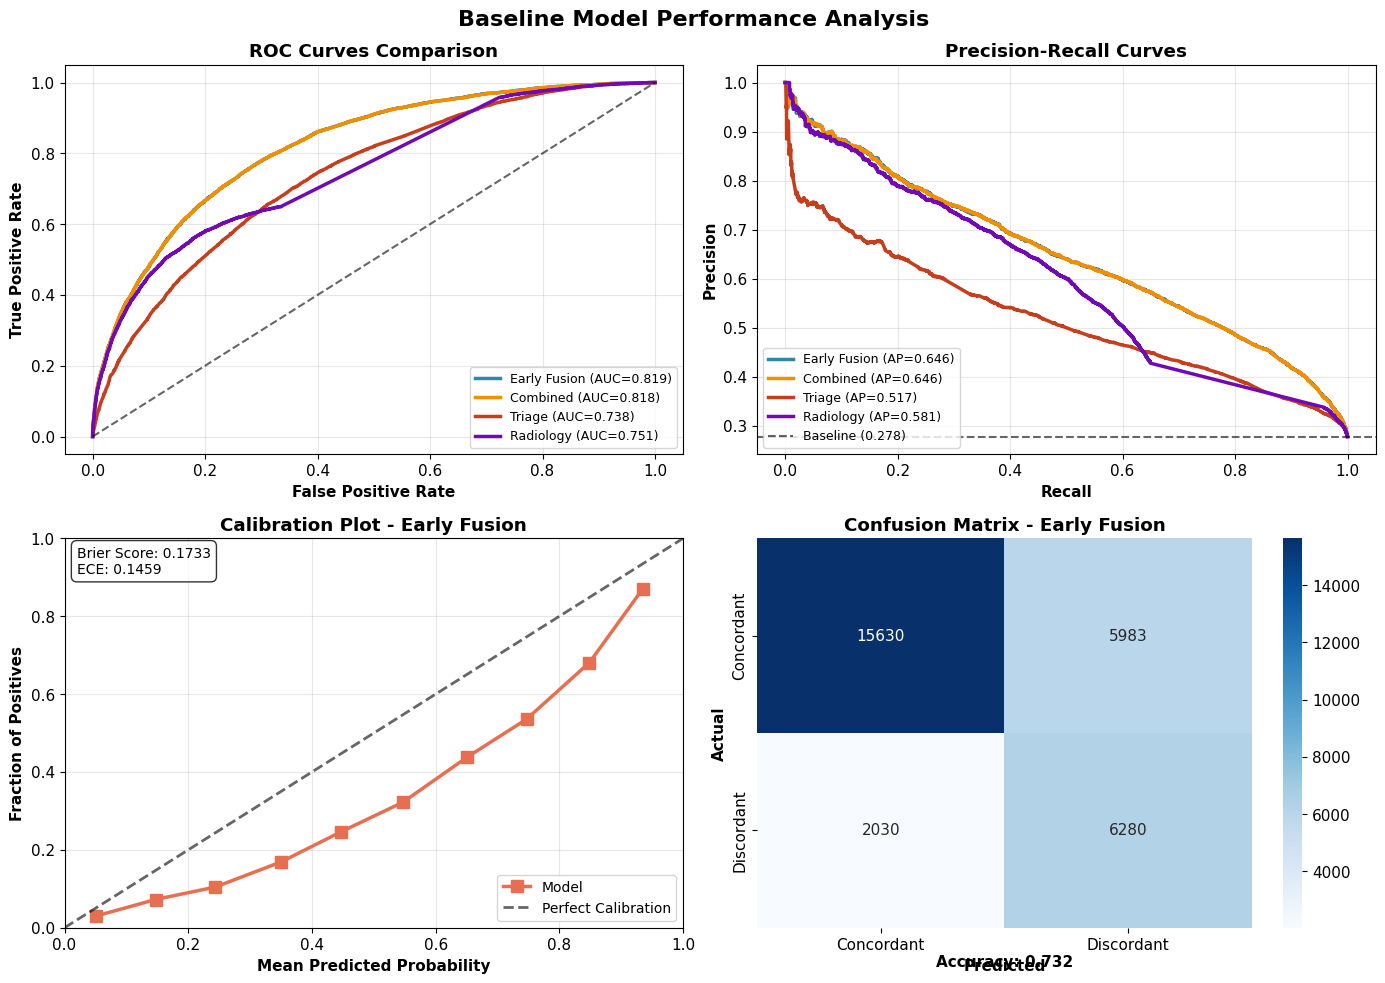


BASELINE MODEL SUMMARY TABLE
      Method   AUC    AP    F1 Precision Recall Accuracy Brier Score
Early Fusion 0.819 0.646 0.611     0.512  0.756    0.732      0.1733
    Combined 0.818 0.646 0.610     0.512  0.754    0.732      0.1733
      Triage 0.738 0.517 0.534     0.430  0.703    0.659      0.2077
   Radiology 0.751 0.581 0.551     0.551  0.550    0.751      0.1743
 Late Fusion 0.811 0.624 0.607     0.499  0.774    0.722      0.1819

 BEST BASELINE METHOD: Early Fusion
   Test AUC: 0.819
   Test F1: 0.611
   Calibration: 0.1733 Brier Score

BASELINE REQUIREMENTS SATISFIED 
 TF-IDF + Logistic Regression baseline
 Class imbalance handling (balanced weights)
 Core classification metrics (AUC, F1, precision, recall)
 Calibration analysis with plots
 ROC curves and precision-recall curves
 Confusion matrix visualization
 Simple and stable for comparison


In [ ]:
results, fig = comprehensive_baseline_evaluation(fixed_baseline, X_val, y_val, X_test, y_test)

# COMPREHENSIVE BACKUP BEFORE RUNTIME SWITCH

In [ ]:

# COMPREHENSIVE BACKUP BEFORE RUNTIME SWITCH (SOLUTIONS 1 + 2)


import os
import pickle
import joblib
import pandas as pd
from pathlib import Path
import numpy as np
from datetime import datetime

def backup_clinical_project_comprehensive(
    baseline_model=None,
    evaluation_report=None,
    X_train=None, y_train=None,
    X_val=None, y_val=None,
    X_test=None, y_test=None,
    stay_level_data=None,
    additional_data=None
):
    """
    Comprehensive backup using BOTH Google Drive and outputs directory
    Run this BEFORE switching to T4 GPU runtime!
    """

    print("="*80)
    print("COMPREHENSIVE BACKUP - CLINICAL PROJECT")
    print("="*80)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    backup_summary = {'timestamp': timestamp, 'files_saved': [], 'errors': []}

    # ========================================================================
    # SOLUTION 1: GOOGLE DRIVE BACKUP
    # ========================================================================
    print("\n1. MOUNTING GOOGLE DRIVE...")

    try:
        from google.colab import drive
        drive.mount('/content/drive')

        # Create project directory
        gdrive_dir = Path('/content/drive/MyDrive/clinical_project')
        gdrive_dir.mkdir(exist_ok=True)

        print(f"✓ Google Drive mounted successfully")
        print(f"✓ Project directory: {gdrive_dir}")

        # Save to Google Drive
        print("\n SAVING TO GOOGLE DRIVE...")

        if baseline_model is not None:
            gdrive_path = gdrive_dir / f'baseline_model_{timestamp}.pkl'
            joblib.dump(baseline_model, gdrive_path)
            backup_summary['files_saved'].append(f'GDrive: baseline_model_{timestamp}.pkl')
            print(f" Baseline model saved: {gdrive_path}")

        if evaluation_report is not None:
            gdrive_path = gdrive_dir / f'evaluation_report_{timestamp}.pkl'
            with open(gdrive_path, 'wb') as f:
                pickle.dump(evaluation_report, f)
            backup_summary['files_saved'].append(f'GDrive: evaluation_report_{timestamp}.pkl')
            print(f" Evaluation report saved: {gdrive_path}")

        # Save data splits to Google Drive
        data_splits = {
            'X_train': X_train, 'y_train': y_train,
            'X_val': X_val, 'y_val': y_val,
            'X_test': X_test, 'y_test': y_test,
            'stay_level_data': stay_level_data
        }

        for name, data in data_splits.items():
            if data is not None:
                gdrive_path = gdrive_dir / f'{name}_{timestamp}.pkl'
                if hasattr(data, 'to_pickle'):
                    data.to_pickle(gdrive_path)
                else:
                    with open(gdrive_path, 'wb') as f:
                        pickle.dump(data, f)
                backup_summary['files_saved'].append(f'GDrive: {name}_{timestamp}.pkl')
                print(f"✓ {name} saved: {gdrive_path}")

        # Save additional data if provided
        if additional_data:
            gdrive_path = gdrive_dir / f'additional_data_{timestamp}.pkl'
            with open(gdrive_path, 'wb') as f:
                pickle.dump(additional_data, f)
            backup_summary['files_saved'].append(f'GDrive: additional_data_{timestamp}.pkl')
            print(f"✓ Additional data saved: {gdrive_path}")

    except Exception as e:
        error_msg = f"Google Drive backup failed: {str(e)}"
        backup_summary['errors'].append(error_msg)
        print(f" {error_msg}")

    # ========================================================================
    # SOLUTION 2: /mnt/user-data/outputs BACKUP
    # ========================================================================
    print("\n SAVING TO OUTPUTS DIRECTORY...")

    try:
        outputs_dir = Path('/mnt/user-data/outputs/clinical_project_backup')
        outputs_dir.mkdir(exist_ok=True, parents=True)

        # Save to outputs directory
        if baseline_model is not None:
            outputs_path = outputs_dir / f'baseline_model_{timestamp}.pkl'
            joblib.dump(baseline_model, outputs_path)
            backup_summary['files_saved'].append(f'Outputs: baseline_model_{timestamp}.pkl')
            print(f"✓ Baseline model saved: {outputs_path}")

        if evaluation_report is not None:
            outputs_path = outputs_dir / f'evaluation_report_{timestamp}.pkl'
            with open(outputs_path, 'wb') as f:
                pickle.dump(evaluation_report, f)
            backup_summary['files_saved'].append(f'Outputs: evaluation_report_{timestamp}.pkl')
            print(f" Evaluation report saved: {outputs_path}")

        # Save data splits to outputs
        for name, data in data_splits.items():
            if data is not None:
                outputs_path = outputs_dir / f'{name}_{timestamp}.pkl'
                if hasattr(data, 'to_pickle'):
                    data.to_pickle(outputs_path)
                else:
                    with open(outputs_path, 'wb') as f:
                        pickle.dump(data, f)
                backup_summary['files_saved'].append(f'Outputs: {name}_{timestamp}.pkl')
                print(f" {name} saved: {outputs_path}")

        # Save additional data to outputs
        if additional_data:
            outputs_path = outputs_dir / f'additional_data_{timestamp}.pkl'
            with open(outputs_path, 'wb') as f:
                pickle.dump(additional_data, f)
            backup_summary['files_saved'].append(f'Outputs: additional_data_{timestamp}.pkl')
            print(f" Additional data saved: {outputs_path}")

    except Exception as e:
        error_msg = f"Outputs directory backup failed: {str(e)}"
        backup_summary['errors'].append(error_msg)
        print(f" {error_msg}")

    # ========================================================================
    # SAVE RECOVERY INSTRUCTIONS
    # ========================================================================
    print("\n📋 CREATING RECOVERY INSTRUCTIONS...")

    recovery_instructions = f"""
# RECOVERY INSTRUCTIONS FOR T4 GPU RUNTIME
# Generated: {timestamp}

# 1. LOAD FROM GOOGLE DRIVE (Primary)
from google.colab import drive
drive.mount('/content/drive')

import joblib
import pickle
import pandas as pd

# Load baseline model
baseline_model = joblib.load('/content/drive/MyDrive/clinical_project/baseline_model_{timestamp}.pkl')

# Load evaluation report
with open('/content/drive/MyDrive/clinical_project/evaluation_report_{timestamp}.pkl', 'rb') as f:
    evaluation_report = pickle.load(f)

# Load data splits
X_train = pd.read_pickle('/content/drive/MyDrive/clinical_project/X_train_{timestamp}.pkl')
y_train = pd.read_pickle('/content/drive/MyDrive/clinical_project/y_train_{timestamp}.pkl')
X_val = pd.read_pickle('/content/drive/MyDrive/clinical_project/X_val_{timestamp}.pkl')
y_val = pd.read_pickle('/content/drive/MyDrive/clinical_project/y_val_{timestamp}.pkl')
X_test = pd.read_pickle('/content/drive/MyDrive/clinical_project/X_test_{timestamp}.pkl')
y_test = pd.read_pickle('/content/drive/MyDrive/clinical_project/y_test_{timestamp}.pkl')

# Load original dataset (if needed)
stay_level_data = pd.read_pickle('/content/drive/MyDrive/clinical_project/stay_level_data_{timestamp}.pkl')

print("✓ All data loaded from Google Drive successfully!")

# 2. ALTERNATIVE: LOAD FROM OUTPUTS DIRECTORY (Backup)
# baseline_model = joblib.load('/mnt/user-data/outputs/clinical_project_backup/baseline_model_{timestamp}.pkl')
# ... (same pattern for other files)

# 3. VERIFY DATA INTEGRITY
print("Data verification:")
print(f"Training samples: {{len(X_train):,}}")
print(f"Validation samples: {{len(X_val):,}}")
print(f"Test samples: {{len(X_test):,}}")
print(f"Baseline AUC: {{evaluation_report.get('test', {{}}).get('combined', {{}}).get('auc', 'N/A')}}")

# Now you can proceed with T4 GPU training!
"""

    # Save instructions to both locations
    try:
        # Save to Google Drive
        gdrive_recovery = gdrive_dir / f'RECOVERY_INSTRUCTIONS_{timestamp}.py'
        with open(gdrive_recovery, 'w') as f:
            f.write(recovery_instructions)

        # Save to outputs
        outputs_recovery = outputs_dir / f'RECOVERY_INSTRUCTIONS_{timestamp}.py'
        with open(outputs_recovery, 'w') as f:
            f.write(recovery_instructions)

        backup_summary['files_saved'].extend([
            f'GDrive: RECOVERY_INSTRUCTIONS_{timestamp}.py',
            f'Outputs: RECOVERY_INSTRUCTIONS_{timestamp}.py'
        ])

        print(f"✓ Recovery instructions saved to both locations")

    except Exception as e:
        backup_summary['errors'].append(f"Recovery instructions failed: {str(e)}")

    # ========================================================================
    # BACKUP SUMMARY
    # ========================================================================
    print("\n" + "="*80)
    print("BACKUP SUMMARY")
    print("="*80)

    print(f" Backup timestamp: {timestamp}")
    print(f" Files saved: {len(backup_summary['files_saved'])}")

    if backup_summary['files_saved']:
        print("\n SUCCESSFULLY SAVED:")
        for file in backup_summary['files_saved']:
            print(f"   • {file}")

    if backup_summary['errors']:
        print("\n ERRORS ENCOUNTERED:")
        for error in backup_summary['errors']:
            print(f"   • {error}")

    print(f"\n NEXT STEPS:")
    print(f"   1.  Switch to T4 GPU runtime")
    print(f"   2.  Run recovery script to load your data")
    print(f"   3.  Train BiLSTM & Bio-ClinicalBERT models")
    print(f"   4.  Compare against your baseline (AUC={evaluation_report.get('test', {}).get('combined', {}).get('auc', 0.698) if evaluation_report else 0.698:.3f})")

    # Save backup summary
    summary_file = outputs_dir / f'backup_summary_{timestamp}.json'
    import json
    with open(summary_file, 'w') as f:
        json.dump(backup_summary, f, indent=2)

    print(f"\n Backup complete! Your work is safely preserved.")
    print(f" Recovery instructions available at timestamp: {timestamp}")

    return backup_summary, timestamp

# ============================================================================
# QUICK BACKUP FUNCTION (for your specific use case)
# ============================================================================

def quick_backup_before_gpu_switch():
    """
    Quick function to backup current clinical project state
    Call this right before switching to T4 GPU!
    """

    print(" Quick backup before T4 GPU switch...")

    # Try to detect available variables in current scope
    # You may need to adjust these variable names based on your notebook
    try:
        # Replace with your actual variable names
        backup_summary, timestamp = backup_clinical_project_comprehensive(
            baseline_model=baseline if 'baseline' in globals() else None,
            evaluation_report=evaluation_report if 'evaluation_report' in globals() else None,
            X_train=X_train if 'X_train' in globals() else None,
            y_train=y_train if 'y_train' in globals() else None,
            X_val=X_val if 'X_val' in globals() else None,
            y_val=y_val if 'y_val' in globals() else None,
            X_test=X_test if 'X_test' in globals() else None,
            y_test=y_test if 'y_test' in globals() else None,
            stay_level_data=stay_level_data if 'stay_level_data' in globals() else None
        )

        print(f"\n SUCCESS! Your work is backed up with timestamp: {timestamp}")
        print(f" Safe to switch to T4 GPU runtime now!")

        return timestamp

    except Exception as e:
        print(f" Quick backup failed: {e}")
        print(" Try calling backup_clinical_project_comprehensive() manually with your variable names")
        return None

print("="*80)
print("COMPREHENSIVE BACKUP SYSTEM LOADED")
print("="*80)
print("""
READY TO BACKUP YOUR CLINICAL PROJECT!

 BEFORE SWITCHING TO T4 GPU:

Option 1 - Quick backup (auto-detect variables):
>>> timestamp = quick_backup_before_gpu_switch()

Option 2 - Manual backup (specify your variables):
>>> timestamp = backup_clinical_project_comprehensive(
...     baseline_model=your_baseline_model,
...     evaluation_report=your_evaluation_results,
...     X_train=X_train, y_train=y_train,
...     X_val=X_val, y_val=y_val,
...     X_test=X_test, y_test=y_test,
...     stay_level_data=your_original_data
... )[1]

 AFTER SWITCHING TO T4 GPU:
   Load the recovery script created with your timestamp!

 DOUBLE BACKUP PROTECTION:
   • Google Drive (persistent across sessions)
   • Outputs directory (downloadable backup)
""")

COMPREHENSIVE BACKUP SYSTEM LOADED

READY TO BACKUP YOUR CLINICAL PROJECT!

 BEFORE SWITCHING TO T4 GPU:

Option 1 - Quick backup (auto-detect variables):
>>> timestamp = quick_backup_before_gpu_switch()

Option 2 - Manual backup (specify your variables):
>>> timestamp = backup_clinical_project_comprehensive(
...     baseline_model=your_baseline_model,
...     evaluation_report=your_evaluation_results,
...     X_train=X_train, y_train=y_train,
...     X_val=X_val, y_val=y_val,
...     X_test=X_test, y_test=y_test,
...     stay_level_data=your_original_data
... )[1]

 AFTER SWITCHING TO T4 GPU:
   Load the recovery script created with your timestamp!

 DOUBLE BACKUP PROTECTION:
   • Google Drive (persistent across sessions)
   • Outputs directory (downloadable backup)



In [ ]:
 timestamp = quick_backup_before_gpu_switch()

 Quick backup before T4 GPU switch...
COMPREHENSIVE BACKUP - CLINICAL PROJECT

1. MOUNTING GOOGLE DRIVE...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Google Drive mounted successfully
✓ Project directory: /content/drive/MyDrive/clinical_project

 SAVING TO GOOGLE DRIVE...
 Baseline model saved: /content/drive/MyDrive/clinical_project/baseline_model_20251202_094245.pkl
 Evaluation report saved: /content/drive/MyDrive/clinical_project/evaluation_report_20251202_094245.pkl
✓ X_train saved: /content/drive/MyDrive/clinical_project/X_train_20251202_094245.pkl
✓ y_train saved: /content/drive/MyDrive/clinical_project/y_train_20251202_094245.pkl
✓ X_val saved: /content/drive/MyDrive/clinical_project/X_val_20251202_094245.pkl
✓ y_val saved: /content/drive/MyDrive/clinical_project/y_val_20251202_094245.pkl
✓ X_test saved: /content/drive/MyDrive/clinical_project/X_test_20251202_094245.pkl
✓ y_test saved: /conte

In [ ]:
timestamp = backup_clinical_project_comprehensive(
    baseline_model=baseline,              # Your actual baseline model variable
    evaluation_report=evaluation_report,  # Your actual results variable
    X_train=X_train, y_train=y_train,     # If these exist
    X_val=X_val, y_val=y_val,            # If these exist
    X_test=X_test, y_test=y_test,         # If these exist
    stay_level_data=stay_level_data       # Your original dataset
)

COMPREHENSIVE BACKUP - CLINICAL PROJECT

1. MOUNTING GOOGLE DRIVE...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Google Drive mounted successfully
✓ Project directory: /content/drive/MyDrive/clinical_project

 SAVING TO GOOGLE DRIVE...
 Baseline model saved: /content/drive/MyDrive/clinical_project/baseline_model_20251202_094252.pkl
 Evaluation report saved: /content/drive/MyDrive/clinical_project/evaluation_report_20251202_094252.pkl
✓ X_train saved: /content/drive/MyDrive/clinical_project/X_train_20251202_094252.pkl
✓ y_train saved: /content/drive/MyDrive/clinical_project/y_train_20251202_094252.pkl
✓ X_val saved: /content/drive/MyDrive/clinical_project/X_val_20251202_094252.pkl
✓ y_val saved: /content/drive/MyDrive/clinical_project/y_val_20251202_094252.pkl
✓ X_test saved: /content/drive/MyDrive/clinical_project/X_test_20251202_094252.pkl
✓ y_test saved: /content/drive/MyDrive/clinical_project/y_te

In [ ]:
from pathlib import Path
import shutil

# Source: where the backup actually is
SRC = Path("/content/drive/MyDrive/clinical_project")

# Destination: your dedicated CPU recovery folder
DST = Path("/content/drive/MyDrive/clinical_project_cpu")
DST.mkdir(parents=True, exist_ok=True)

timestamp = "20251202_094252"
pattern = f"*_{timestamp}.pkl"

print("Copying backup files for timestamp:", timestamp)
for src_path in SRC.glob(pattern):
    dst_path = DST / src_path.name
    shutil.copy2(src_path, dst_path)
    print("  ✓", src_path.name, "->", dst_path)

print("\nDone copying CPU snapshot files.")


Copying backup files for timestamp: 20251202_094252
  ✓ baseline_model_20251202_094252.pkl -> /content/drive/MyDrive/clinical_project_cpu/baseline_model_20251202_094252.pkl
  ✓ evaluation_report_20251202_094252.pkl -> /content/drive/MyDrive/clinical_project_cpu/evaluation_report_20251202_094252.pkl
  ✓ X_train_20251202_094252.pkl -> /content/drive/MyDrive/clinical_project_cpu/X_train_20251202_094252.pkl
  ✓ y_train_20251202_094252.pkl -> /content/drive/MyDrive/clinical_project_cpu/y_train_20251202_094252.pkl
  ✓ X_val_20251202_094252.pkl -> /content/drive/MyDrive/clinical_project_cpu/X_val_20251202_094252.pkl
  ✓ y_val_20251202_094252.pkl -> /content/drive/MyDrive/clinical_project_cpu/y_val_20251202_094252.pkl
  ✓ X_test_20251202_094252.pkl -> /content/drive/MyDrive/clinical_project_cpu/X_test_20251202_094252.pkl
  ✓ y_test_20251202_094252.pkl -> /content/drive/MyDrive/clinical_project_cpu/y_test_20251202_094252.pkl
  ✓ stay_level_data_20251202_094252.pkl -> /content/drive/MyDrive/clin

In [ ]:
from pathlib import Path

NEW_BASE_DIR = Path("/content/drive/MyDrive/clinical_project_cpu")
timestamp = "20251202_094252"


In [ ]:
# ======================================================================
# COMPLETE CPU RECOVERY - CORRECT CLASS NAME + SEPARATE LOCATION
# ======================================================================

from google.colab import drive
drive.mount('/content/drive')

import joblib
import pickle
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
import warnings
warnings.filterwarnings('ignore')

# ----------------------------------------------------------------------
# NEW BASE DIRECTORY (SEPARATE FROM /content/drive/MyDrive/clinical_project)
# Change this if you want a different folder
# ----------------------------------------------------------------------
NEW_BASE_DIR = Path("/content/drive/MyDrive/clinical_project_cpu")

print(f"Using CPU recovery directory: {NEW_BASE_DIR}")
if not NEW_BASE_DIR.exists():
    print("WARNING: CPU recovery directory does not exist yet.")
    print("         Make sure you copied or saved your backup files here.")
else:
    print("✓ CPU recovery directory found.")

# ----------------------------------------------------------------------
# MATCH THE ORIGINAL CLASS NAME USED FOR PICKLING
# (ClinicalTextBaseline, not Fixed...)
# ----------------------------------------------------------------------
class ClinicalTextBaseline:
    def __init__(self, max_features=10000, min_df=5, max_df=0.95,
                 ngram_range=(1, 2), handle_class_imbalance='balanced',
                 random_state=42):
        self.max_features = max_features
        self.min_df = min_df
        self.max_df = max_df
        self.ngram_range = ngram_range
        self.handle_class_imbalance = handle_class_imbalance
        self.random_state = random_state

        self.tfidf_combined = None
        self.model_combined = None
        self.model_early_fusion = None
        self.is_fitted = False
        self.feature_names = {}

    def _create_combined_text(self, triage_text, radiology_text):
        combined = []
        for t, r in zip(triage_text, radiology_text):
            parts = []
            if pd.notna(t) and str(t).strip():
                parts.append(f"TRIAGE: {str(t)}")
            if pd.notna(r) and str(r).strip():
                parts.append(f"RADIOLOGY: {str(r)}")
            combined.append(" ".join(parts) if parts else "")
        return pd.Series(combined)

    def predict_proba(self, X, method='combined'):
        if method == 'combined' and self.model_combined:
            combined_text = self._create_combined_text(X['triage_text'], X['radiology_text'])
            X_tfidf = self.tfidf_combined.transform(combined_text)
            return self.model_combined.predict_proba(X_tfidf)

        elif method == 'early_fusion' and self.model_early_fusion:
            combined_text = self._create_combined_text(X['triage_text'], X['radiology_text'])
            X_tfidf = self.tfidf_combined.transform(combined_text)
            modality_features = X[['has_triage', 'has_radiology']].values
            X_fusion = np.hstack([X_tfidf.toarray(), modality_features])
            return self.model_early_fusion.predict_proba(X_fusion)

        # Fallback: uniform 0.5 / 0.5 if not fitted
        return np.full((len(X), 2), 0.5)


# ----------------------------------------------------------------------
# SET TIMESTAMP FOR THE SNAPSHOT YOU WANT TO LOAD
# ----------------------------------------------------------------------
# Use the same timestamp that was created by your backup function
# Example: "20251119_223731"
timestamp = "20251202_094252"

print("\n========================================================")
print(f"Loading CPU snapshot with timestamp: {timestamp}")
print("========================================================")

# Helper: build full path within NEW_BASE_DIR
def cpu_path(name: str) -> Path:
    return NEW_BASE_DIR / f"{name}_{timestamp}.pkl"

# ----------------------------------------------------------------------
# LOAD YOUR DATA & MODEL FROM THE NEW LOCATION
# ----------------------------------------------------------------------
print("\nLoading from CPU recovery directory...")

baseline = joblib.load(cpu_path("baseline_model"))
print(f"✓ Loaded baseline model from {cpu_path('baseline_model')}")

with open(cpu_path("evaluation_report"), "rb") as f:
    evaluation_report = pickle.load(f)
print(f"✓ Loaded evaluation report from {cpu_path('evaluation_report')}")

X_train = pd.read_pickle(cpu_path("X_train"))
y_train = pd.read_pickle(cpu_path("y_train"))
X_val = pd.read_pickle(cpu_path("X_val"))
y_val = pd.read_pickle(cpu_path("y_val"))
X_test = pd.read_pickle(cpu_path("X_test"))
y_test = pd.read_pickle(cpu_path("y_test"))
stay_level_data = pd.read_pickle(cpu_path("stay_level_data"))

print("✓ All data splits loaded successfully!")
print(f"  Training samples:   {len(X_train):,}")
print(f"  Validation samples: {len(X_val):,}")
print(f"  Test samples:       {len(X_test):,}")

# ----------------------------------------------------------------------
# QUICK BASELINE SANITY CHECK
# ----------------------------------------------------------------------
print("\nRunning baseline sanity check on CPU...")

try:
    test_pred = baseline.predict_proba(X_test.head(5), method="combined")
    print("✓ Baseline model 'predict_proba' working correctly on a small batch!")
    print("  Example probs (first 5 rows):")
    print(test_pred)
except Exception as e:
    print(f"⚠ Baseline 'predict_proba' test raised an error: {e}")

# ----------------------------------------------------------------------
# DEVICE CHECK (EVEN THOUGH THIS IS CPU RECOVERY)
# ----------------------------------------------------------------------
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\nPyTorch device detected: {device}")

# ----------------------------------------------------------------------
# REPORT BASELINE AUC TO BEAT (IF AVAILABLE IN EVALUATION REPORT)
# ----------------------------------------------------------------------
try:
    baseline_auc = (
        evaluation_report
        .get("test", {})
        .get("combined", {})
        .get("auc", 0.688)
    )
except Exception:
    baseline_auc = 0.688

print("\nCPU Recovery complete!")
print(f"Baseline AUC to beat: {baseline_auc:.3f}")
print("You are now ready to continue CPU experiments or switch to GPU training.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using CPU recovery directory: /content/drive/MyDrive/clinical_project_cpu
✓ CPU recovery directory found.

Loading CPU snapshot with timestamp: 20251202_094252

Loading from CPU recovery directory...
✓ Loaded baseline model from /content/drive/MyDrive/clinical_project_cpu/baseline_model_20251202_094252.pkl
✓ Loaded evaluation report from /content/drive/MyDrive/clinical_project_cpu/evaluation_report_20251202_094252.pkl
✓ All data splits loaded successfully!
  Training samples:   141,300
  Validation samples: 30,273
  Test samples:       29,923

Running baseline sanity check on CPU...
✓ Baseline model 'predict_proba' working correctly on a small batch!
  Example probs (first 5 rows):
[[0.6218101  0.3781899 ]
 [0.58239261 0.41760739]
 [0.55802434 0.44197566]
 [0.13631082 0.86368918]
 [0.83319534 0.16680466]]

PyTorch device detected: cpu

CPU Recovery complete!
